### Q
- Pourquoi ne s'équilibre pas par ligne ?

## Data loading and preprocessing

In [17]:
from sklearn.base import BaseEstimator
from sklearn.ensemble import *
from sklearn.preprocessing import *
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, roc_auc_score

import missingno as msno
import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import plotly
plotly.offline.init_notebook_mode() # run at the start of every ipython notebook

# Seed
seed = 7
np.random.seed(seed)
pd.set_option('display.max_columns', None)

In [2]:
%matplotlib inline

In [3]:
# Data loading
data_train = pd.read_csv('data/Train.csv', delimiter=";")
data_test = pd.read_csv('data/Test.csv', delimiter=";")
output_df =  pd.read_csv('data/challenge_output_data_training_file_predict_the_crude_oil_production_trend.csv', delimiter=";")

In [4]:
print data_train.shape
print data_test.shape
print output_df.shape

(10159, 123)
(2000, 123)
(10159, 2)


In [5]:
data_train = pd.merge(data_train, output_df, on='ID')

In [6]:
data_train = data_train.rename(columns={"Target" : "y"})

In [82]:
print data_train.shape
data_train.head()

(10159, 124)


ID  month  country  1_diffClosing stocks(kmt)  1_diffExports(kmt)  \
0  ID00001      5       52                     0.0000            237.0000   
1  ID00002     12       69                    28.0000            -34.0000   
2  ID00003      5       74                     0.0000              0.0000   
3  ID00004     11       34                   175.3701             91.5209   
4  ID00005      7        2                  -550.0674            251.9568   

   1_diffImports(kmt)  1_diffRefinery intake(kmt)  1_diffWTI  \
0              0.0000                     33.0000      -5.62   
1             60.0000                      7.0000      -5.95   
2            -29.1227                    -85.5816      -5.62   
3              0.0000                    339.4347       7.66   
4              0.0000                    -49.5277     -12.07   

   1_diffSumClosing stocks(kmt)  1_diffSumExports(kmt)  1_diffSumImports(kmt)  \
0                    10426.2462             12135.1024             20527.7805   
1                      195.2005              7500.1033              6335.0098   
2                    10426.2462             12135.1024             20527.7805   
3                    -2247.4834             -6806.1222            -10986.0493   
4                    -2652.6804              2165.7119             -4491.3056   

   1_diffSumProduction(kmt)  1_diffSumRefinery intake(kmt)  \
0                32234.6302                     25998.8106   
1                12732.1449                      9538.8196   
2                32234.6302                     25998.8106   
3                -6674.2251                    -14749.4891   
4                 8211.1276                      5942.2535   

   2_diffClosing stocks(kmt)  2_diffExports(kmt)  2_diffImports(kmt)  \
0                     0.0000           -159.0000              0.0000   
1                   -70.0000             20.0000              0.0000   
2                     0.0000              0.0000            190.8165   
3                   245.7604            788.8290              0.0000   
4                    43.1848           -353.1714              0.0000   

   2_diffRefinery intake(kmt)  2_diffWTI  2_diffSumClosing stocks(kmt)  \
0                    -17.0000      -5.05                    -3509.9957   
1                     -6.0000       2.31                     1655.5214   
2                    195.2832      -5.05                    -3509.9957   
3                    -89.0982      12.52                     6531.7226   
4                    -80.0270       1.59                    -1421.2644   

   2_diffSumExports(kmt)  2_diffSumImports(kmt)  2_diffSumProduction(kmt)  \
0              1123.9965             -6034.0395                -2105.2971   
1             -3691.7079              -836.2419                -4159.0155   
2              1123.9965             -6034.0395                -2105.2971   
3             11104.3518              5399.6183                12744.7301   
4             -6194.2674              7706.7709               -10581.6649   

   2_diffSumRefinery intake(kmt)  3_diffClosing stocks(kmt)  \
0                     -7860.3692                     0.0000   
1                     -4154.0051                   -19.0000   
2                     -7860.3692                     0.0000   
3                      2258.5159                  -216.9582   
4                      2893.4431                   333.4683   

   3_diffExports(kmt)  3_diffImports(kmt)  3_diffRefinery intake(kmt)  \
0             66.0000              0.0000                     12.0000   
1            107.0000             50.0000                      1.0000   
2              0.0000            -10.3627                    -10.1840   
3            382.0996              0.0000                   -108.7483   
4            219.2983              0.0000                    155.3307   

   3_diffWTI  3_diffSumClosing stocks(kmt)  3_diffSumExports(kmt)  \
0       3.47                    -1389.7911              8409.3483   
1  

In [8]:
data_test.head()

ID  month  country  1_diffClosing stocks(kmt)  1_diffExports(kmt)  \
0  ID10160      8       70                    15.0000                 0.0   
1  ID10161      1       37                   -15.4795                 0.0   
2  ID10162      9        6                   -65.0000               155.0   
3  ID10163      7       22                   156.5714               173.0   
4  ID10164      4       46                   -44.0000               -44.0   

   1_diffImports(kmt)  1_diffRefinery intake(kmt)  1_diffWTI  \
0             31.0000                   -145.0000       2.67   
1             63.1507                     62.3288     -14.59   
2              0.0000                      7.0000      -7.84   
3              0.0000                    -78.7143       0.63   
4              0.0000                    244.0000       2.05   

   1_diffSumClosing stocks(kmt)  1_diffSumExports(kmt)  1_diffSumImports(kmt)  \
0                    -1781.9870             -8987.7760            -10788.9881   
1                    -2593.1638             -5059.3172             -5678.4743   
2                     -364.8415             10673.4778             12380.9353   
3                     5560.8222               910.3264              1711.2441   
4                     2117.1984            -12089.1886            -15761.2775   

   1_diffSumProduction(kmt)  1_diffSumRefinery intake(kmt)  \
0               -10152.2781                    -12700.4009   
1               -10378.0484                     -6675.1075   
2                10282.5840                     14038.1986   
3                 9408.0013                      3833.9495   
4               -28688.8971                    -28772.4931   

   2_diffClosing stocks(kmt)  2_diffExports(kmt)  2_diffImports(kmt)  \
0                   -13.0000              0.0000            275.0000   
1                    36.5754              0.0000             54.9315   
2                    -5.0000            -91.0000              0.0000   
3                   -95.5714             84.1429              0.0000   
4                     0.0000              0.0000              0.0000   

   2_diffRefinery intake(kmt)  2_diffWTI  2_diffSumClosing stocks(kmt)  \
0                    365.0000      -7.84                     -364.8415   
1                      2.8767     -12.49                     1686.0018   
2                    -24.0000      -0.37                    -2531.2443   
3                      1.5714      -0.77                      280.5374   
4                      0.0000      -2.12                     7381.9485   

   2_diffSumExports(kmt)  2_diffSumImports(kmt)  2_diffSumProduction(kmt)  \
0             10673.4778             12380.9353                10282.5840   
1              8250.0877             15593.7823                15907.2569   
2             -9624.2279              3226.0401                -1244.8432   
3             -2773.5920              -510.7432                -8975.0606   
4             12978.5545             16781.7339                31928.8902   

   2_diffSumRefinery intake(kmt)  3_diffClosing stocks(kmt)  \
0                     14038.1986                   -40.0000   
1                     18490.0113                    -2.1918   
2                      6642.0106                    47.0000   
3                     -2098.3683                  -223.8572   
4                     25846.4190                    21.0000   

   3_diffExports(kmt)  3_diffImports(kmt)  3_diffRefinery intake(kmt)  \
0              0.0000           -107.0000                    110.0000   
1              0.0000            -54.5205                    -15.7534   
2           -232.0000              0.0000                     -3.0000   
3            221.4286              0.0000                     29.4286   
4              0.0000              0.0000                     49.0000   

   3_diffWTI  3_diffSumClosing stocks(kmt)  3_diffSumExports(kmt)  \
0      -0.37                    -2531.2443             -9624.2279   
1  

In [49]:
temp = pd.DataFrame(columns=["conso"], data=- data_train["12_diffClosing stocks(kmt)"] - data_train["12_diffExports(kmt)"] + \
    data_train["12_diffImports(kmt)"] + data_train["1_diffRefinery intake(kmt)"])
temp["y"] = data_train["y"]

In [50]:
temp

conso  y
0        33.0000  1
1       112.0000  0
2      -103.4483  0
3       837.5505  0
4      1590.1484  1
5       -66.0000  1
6      -175.8084  0
7       192.0000  0
8         0.0000  0
9      -634.6910  0
10       16.3090  0
11     -111.0000  0
12      154.0000  0
13      144.0000  0
14       90.0000  1
15       59.3902  0
16     -944.0000  0
17       33.0000  0
18       58.7999  0
19     -251.6949  0
20      -87.4293  0
21       36.0000  0
22     -189.0000  0
23     -463.0000  0
24      189.8571  1
25     -695.0000  0
26      396.0000  1
27     -262.0000  1
28     -638.0000  0
29      562.0000  0
...          ... ..
10129  1042.6966  0
10130   139.0000  1
10131  -285.0000  1
10132   305.0000  0
10133  -441.0000  1
10134 -2028.8133  0
10135   -33.1135  1
10136    14.0000  0
10137 -3477.0000  0
10138   327.0000  1
10139    82.0000  0
10140     0.0000  0
10141  -105.0000  0
10142   -20.7629  0
10143        NaN  1
10144    72.0000  0
10145  -980.9655  1
10146   -16.7143  0
10147    25.0000  0
10148  -246.0000  0
10149   407.0000  0
10150   -81.0000  0
10151  -184.0000  0
10152  -132.0000  1
10153     0.0000  1
10154     0.0000  1
10155  -639.0000  1
10156     4.0000  1
10157   209.0000  0
10158  -750.5715  0

[10159 rows x 2 columns]

In [63]:
print (temp[temp["y"]==0]["conso"] > 0).sum() / (temp.shape[0] * 1.0)
print (temp[temp["y"]==1]["conso"] > 0).sum() / (temp.shape[0] * 1.0)

0.27994881386
0.18860124028


In [41]:
print data_train["y"].value_counts() / len(data_train["y"])
print
print data_train.info()

0    0.654001
1    0.345999
Name: y, dtype: float64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10159 entries, 0 to 10158
Columns: 124 entries, ID to y
dtypes: float64(120), int64(3), object(1)
memory usage: 9.7+ MB
None


In [10]:
print 'No. of duplicates in data_train = ', data_train.duplicated().sum()
print 'No. of duplicates in data_test = ', data_test.duplicated().sum()

No. of duplicates in data_train =  0
No. of duplicates in data_test =  0


### NaN values

In [ ]:
print 'No. of columns with NaN values in data_train = ',(data_train.isnull().sum() > 0).sum()
print 'No. of columns with NaN values in data_test = ',(data_test.isnull().sum() > 0).sum()

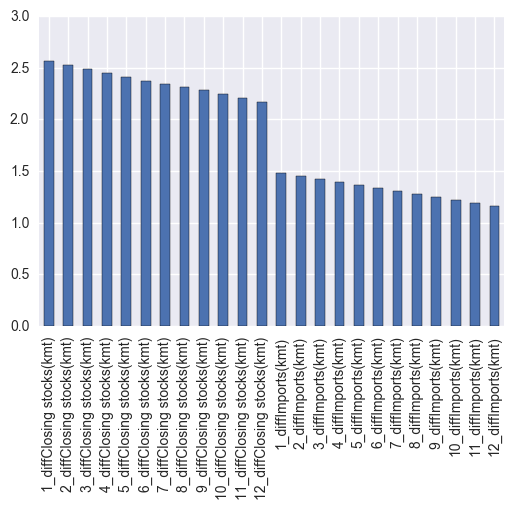

In [12]:
(100 * data_train.isnull().sum() / data_train.shape[0]).sort_values(ascending=False)[:24].plot(kind='bar');

In [13]:
print data_train[data_train.isnull().any(axis=1)].shape
data_train[data_train.isnull().any(axis=1)]

(294, 124)


ID  month  country  1_diffClosing stocks(kmt)  1_diffExports(kmt)  \
73     ID00074     12       41                        NaN            241.3793   
87     ID00088      2       71                        NaN           3546.4719   
143    ID00144      3       41                        NaN            457.5173   
274    ID00275      9       42                        NaN            192.6121   
303    ID00304      5       42                        NaN            466.6227   
304    ID00305      9       42                        NaN            -77.1768   
355    ID00356     10       42                        NaN             -4.0897   
390    ID00391      6       42                        NaN            -27.7044   
404    ID00405     10       71                        NaN            138.7572   
453    ID00454      7       71                        NaN           -651.5272   
466    ID00467      5       42                        NaN            660.9498   
513    ID00514      4       33                        0.0           -806.8027   
520    ID00521      4       42                        NaN           -437.9947   
529    ID00530      7       71                        NaN            440.6266   
557    ID00558      7       41                        NaN           -623.8620   
618    ID00619      3       42                        NaN             40.8971   
633    ID00634      5       33                        NaN             55.3741   
642    ID00643     11       42                        NaN            -93.2717   
655    ID00656     10       42                        NaN             61.3457   
669    ID00670      6       71                        NaN            -24.7499   
696    ID00697      1       42                        NaN           -275.0660   
709    ID00710      3       33                        0.0            -42.1769   
710    ID00711      9       41                        NaN           -111.5862   
723    ID00724      8       41                        NaN           -852.9655   
732    ID00733     11       42                        NaN            213.3245   
791    ID00792      3       41                        NaN           -709.7931   
802    ID00803      5       71                        NaN            291.7324   
908    ID00909      6       33                        0.0           -389.5238   
979    ID00980     11       33                        NaN            177.1429   
1005   ID01006     12       33                        0.0            334.1497   
...        ...    ...      ...                        ...                 ...   
9083   ID09084     12       42                        NaN            130.2111   
9106   ID09107      2       33                        0.0             34.0136   
9125   ID09126     11       71                        NaN           -342.4171   
9131   ID09132     12       33                        NaN            328.9796   
9144   ID09145      8       33                        NaN           -241.9048   
9158   ID09159     12       71                        NaN            246.5772   
9184   ID09185      2       71                        NaN            644.1548   
9203   ID09204      5       41                        NaN            631.5862   
9248   ID09249      1       42                        0.0           -148.6808   
9259   ID09260      2       71                        NaN             30.2791   
9299   ID09300      2       41                        NaN            596.4138   
9304   ID09305      9       71                        NaN           1065.6925   
9320   ID09321      1       71                        NaN             -7.5039   
9428   ID09429     11       42                        NaN             93.6675   
9474   ID09475      8       71                        NaN            837.1512   
9498   ID09499      1       33                        0.0           -384.0816   
9554   ID09555      2       41                        NaN           -271.0345   
9730   ID09731      2       41             

Only missing for 4 countries (African)

In [14]:
data_train[data_train.isnull().any(axis=1)].country.value_counts()

71    84
42    84
41    84
33    42
Name: country, dtype: int64

In [15]:
null_columns = data_train.isnull().any(axis=0)[data_train.isnull().any(axis=0)].index
print null_columns

Index([u'1_diffClosing stocks(kmt)', u'1_diffImports(kmt)',
       u'2_diffClosing stocks(kmt)', u'2_diffImports(kmt)',
       u'3_diffClosing stocks(kmt)', u'3_diffImports(kmt)',
       u'4_diffClosing stocks(kmt)', u'4_diffImports(kmt)',
       u'5_diffClosing stocks(kmt)', u'5_diffImports(kmt)',
       u'6_diffClosing stocks(kmt)', u'6_diffImports(kmt)',
       u'7_diffClosing stocks(kmt)', u'7_diffImports(kmt)',
       u'8_diffClosing stocks(kmt)', u'8_diffImports(kmt)',
       u'9_diffClosing stocks(kmt)', u'9_diffImports(kmt)',
       u'10_diffClosing stocks(kmt)', u'10_diffImports(kmt)',
       u'11_diffClosing stocks(kmt)', u'11_diffImports(kmt)',
       u'12_diffClosing stocks(kmt)', u'12_diffImports(kmt)'],
      dtype='object')


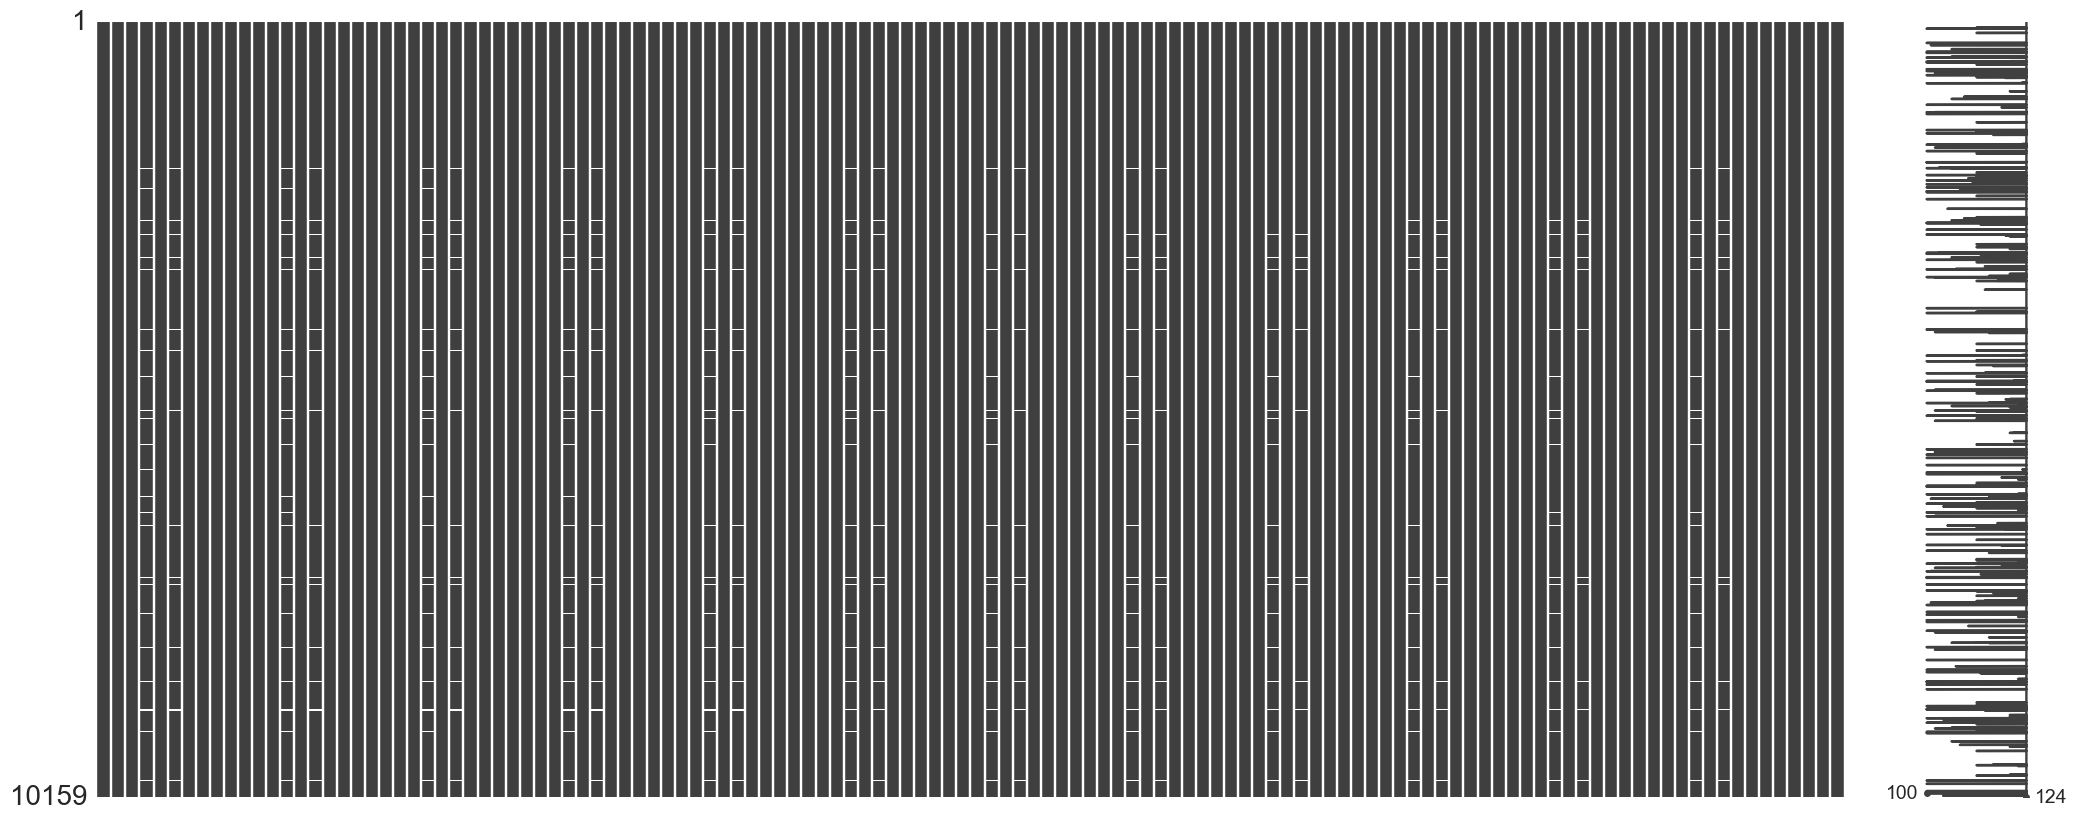

In [16]:
msno.matrix(data_train)

UnboundLocalError: local variable 'pos' referenced before assignment

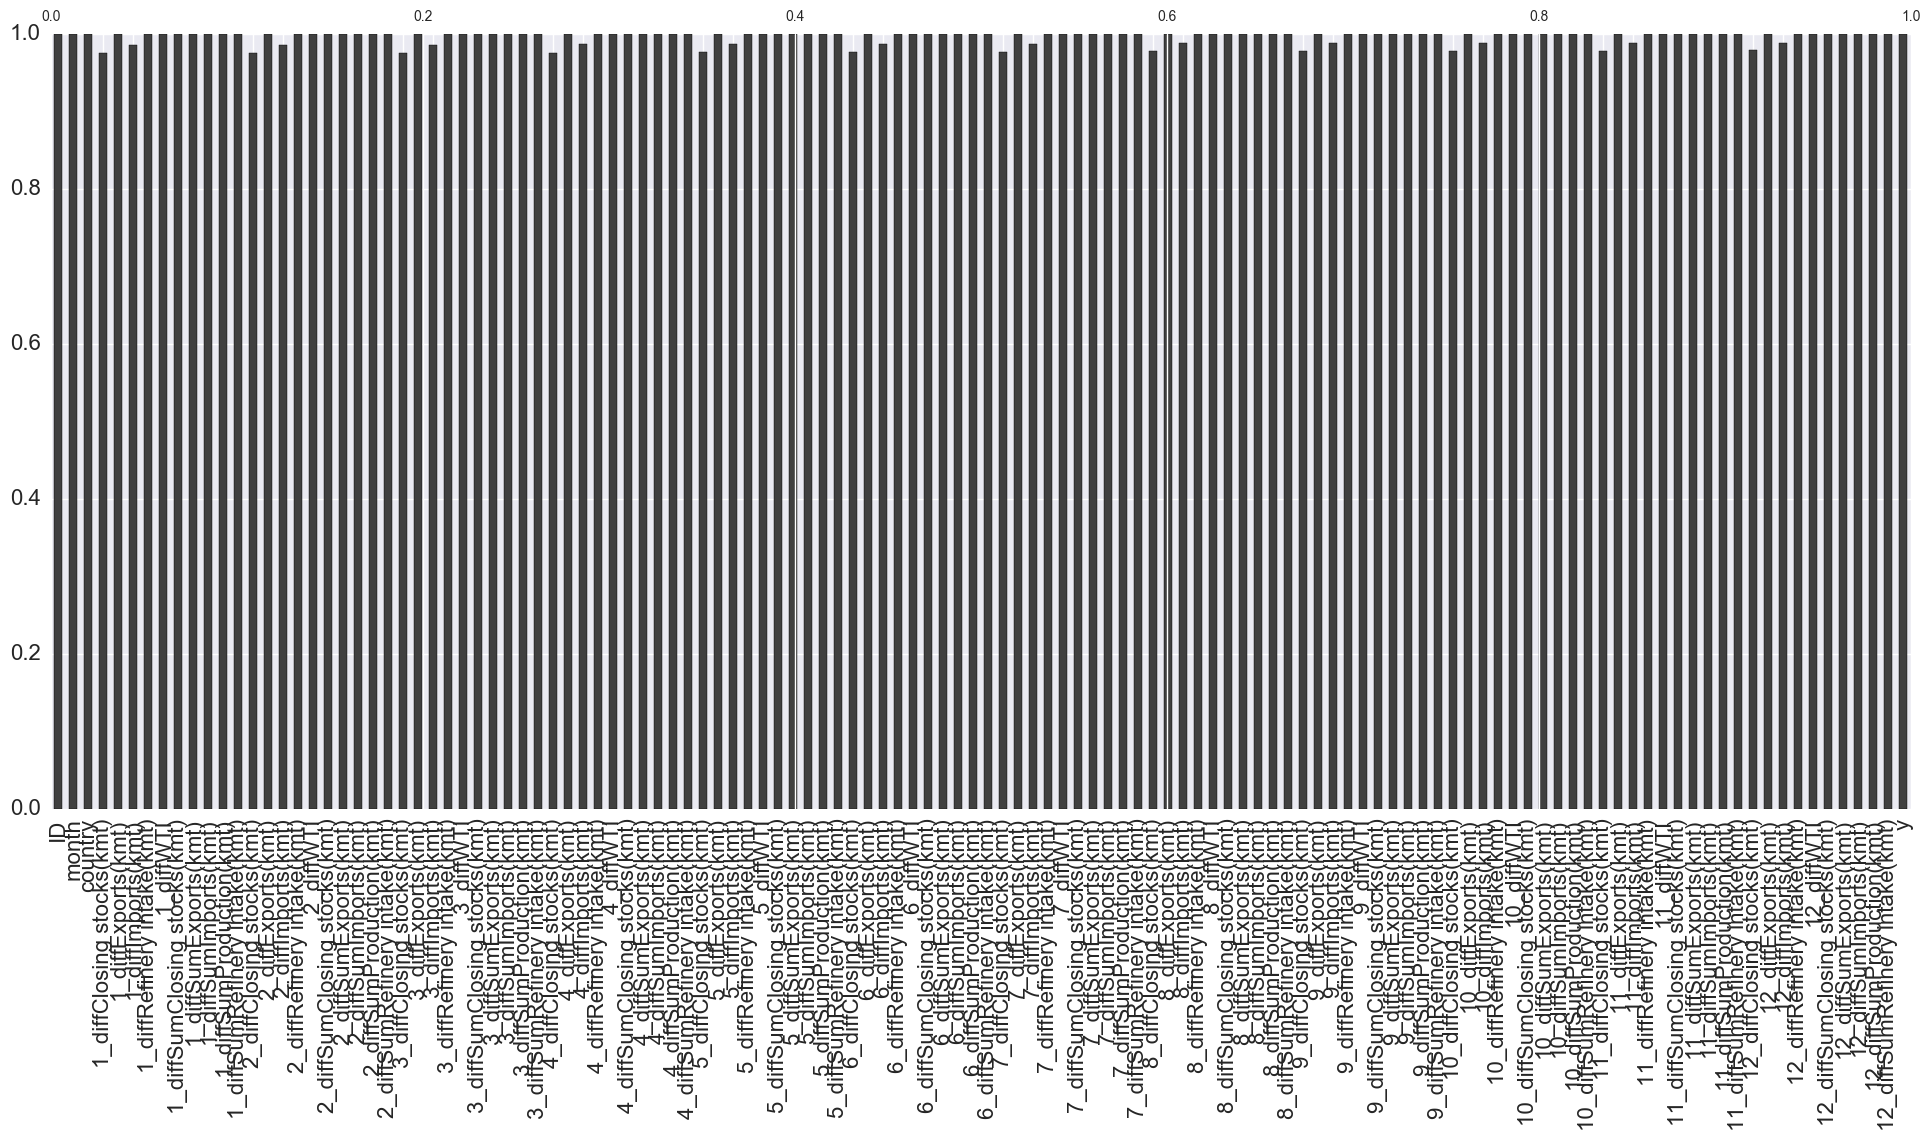

In [17]:
msno.bar(data_train);

#### Nullity correlations
Nullity correlation ranges from -1 (if one variable appears the other definitely does not) to 0 (variables appearing or not appearing have no effect on one another) to 1 (if one variable appears the other definitely also does).  
Entries marked <1 or >-1 are have a correlation that is close to being exactingly negative or positive, but is still not quite perfectly so. This points to a small number of records in the dataset which are erroneous.  
For example, in this dataset the correlation between VEHICLE CODE TYPE 3 and CONTRIBUTING FACTOR VEHICLE 3 is <1, indicating that, contrary to our expectation, there are a few records which have one or the other, but not both.  
These cases will require special attention.  
Note that variables with a variance of zero (that is, variables which are always full or always empty) have no meaningful correlation and so are silently removed from the visualization—in this case for instance the datetime and injury number columns, which are completely filled, are not included.

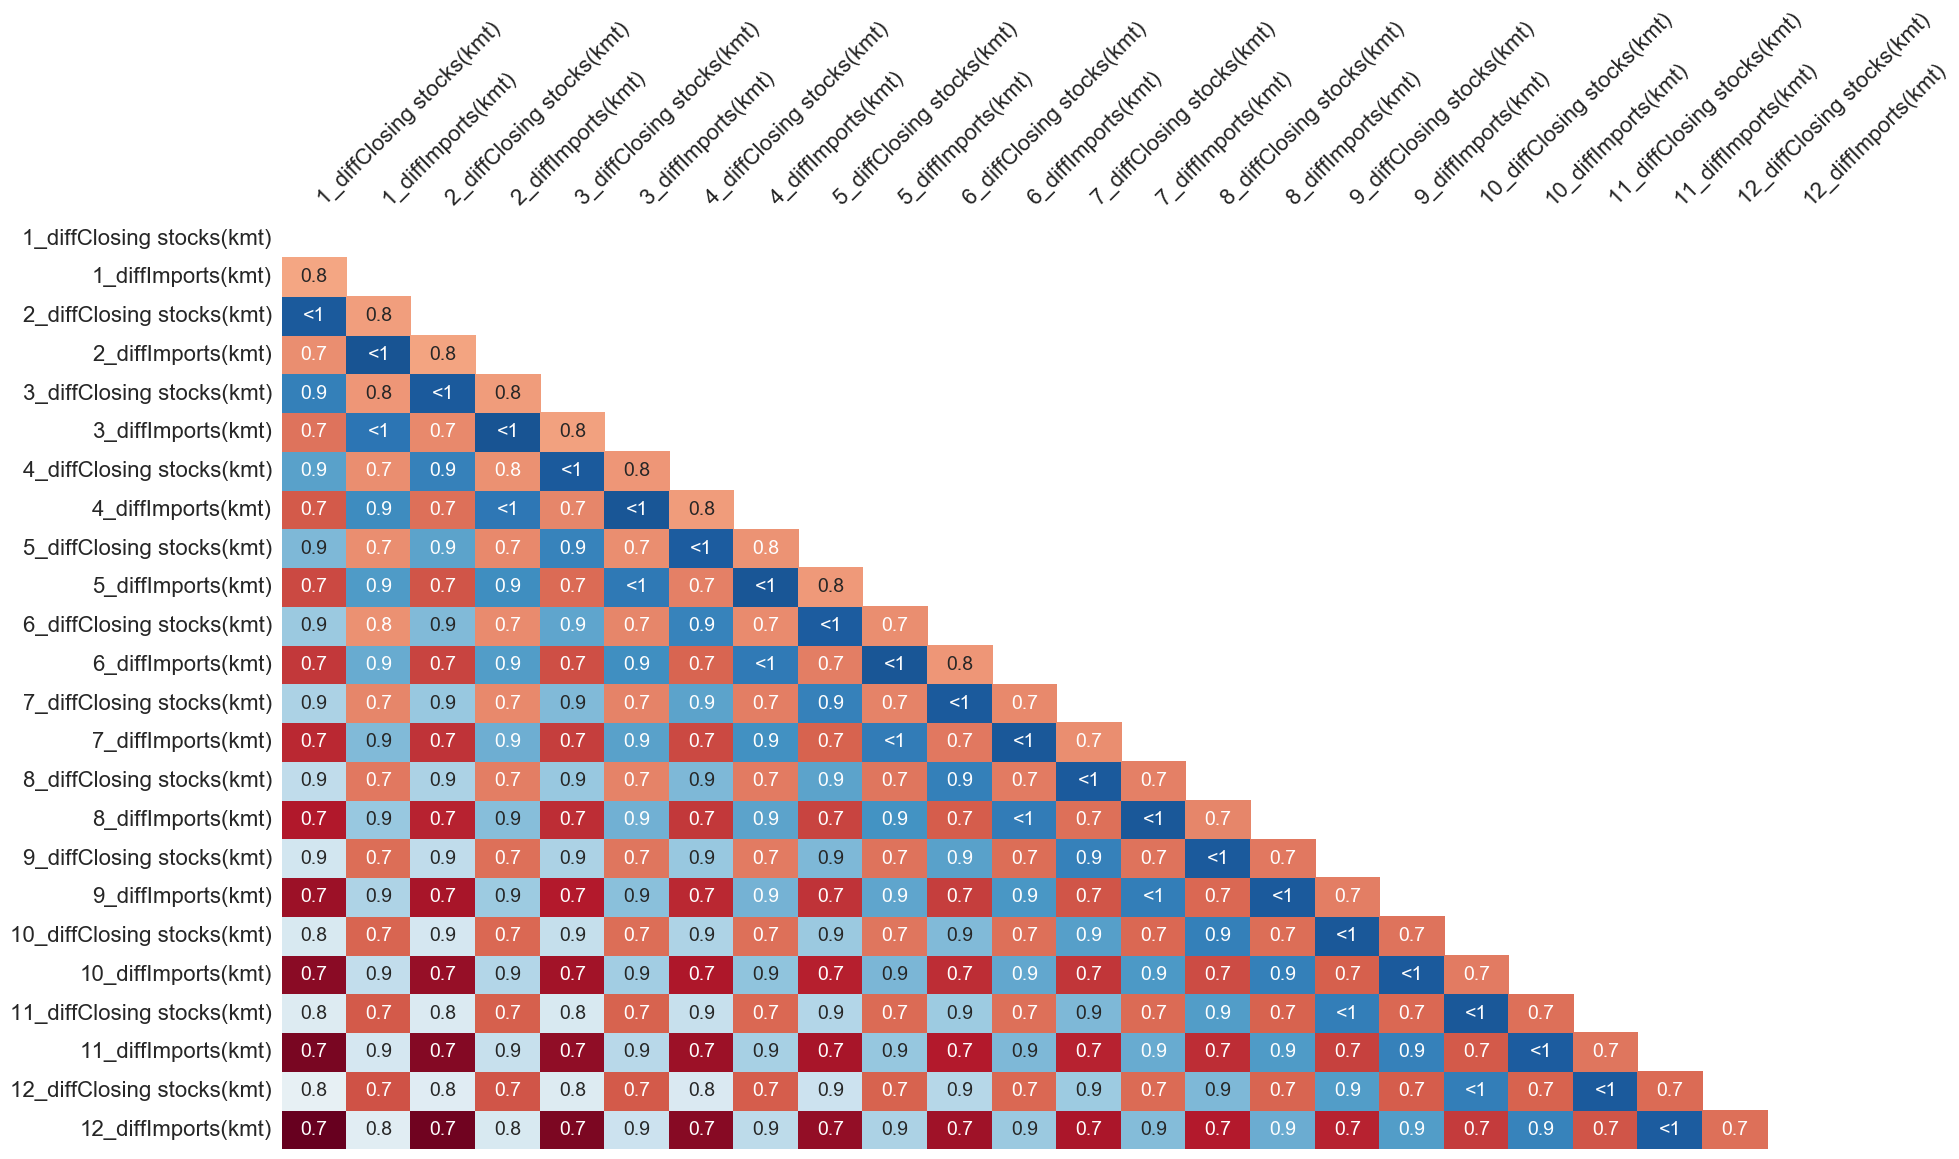

In [18]:
msno.heatmap(data_train)

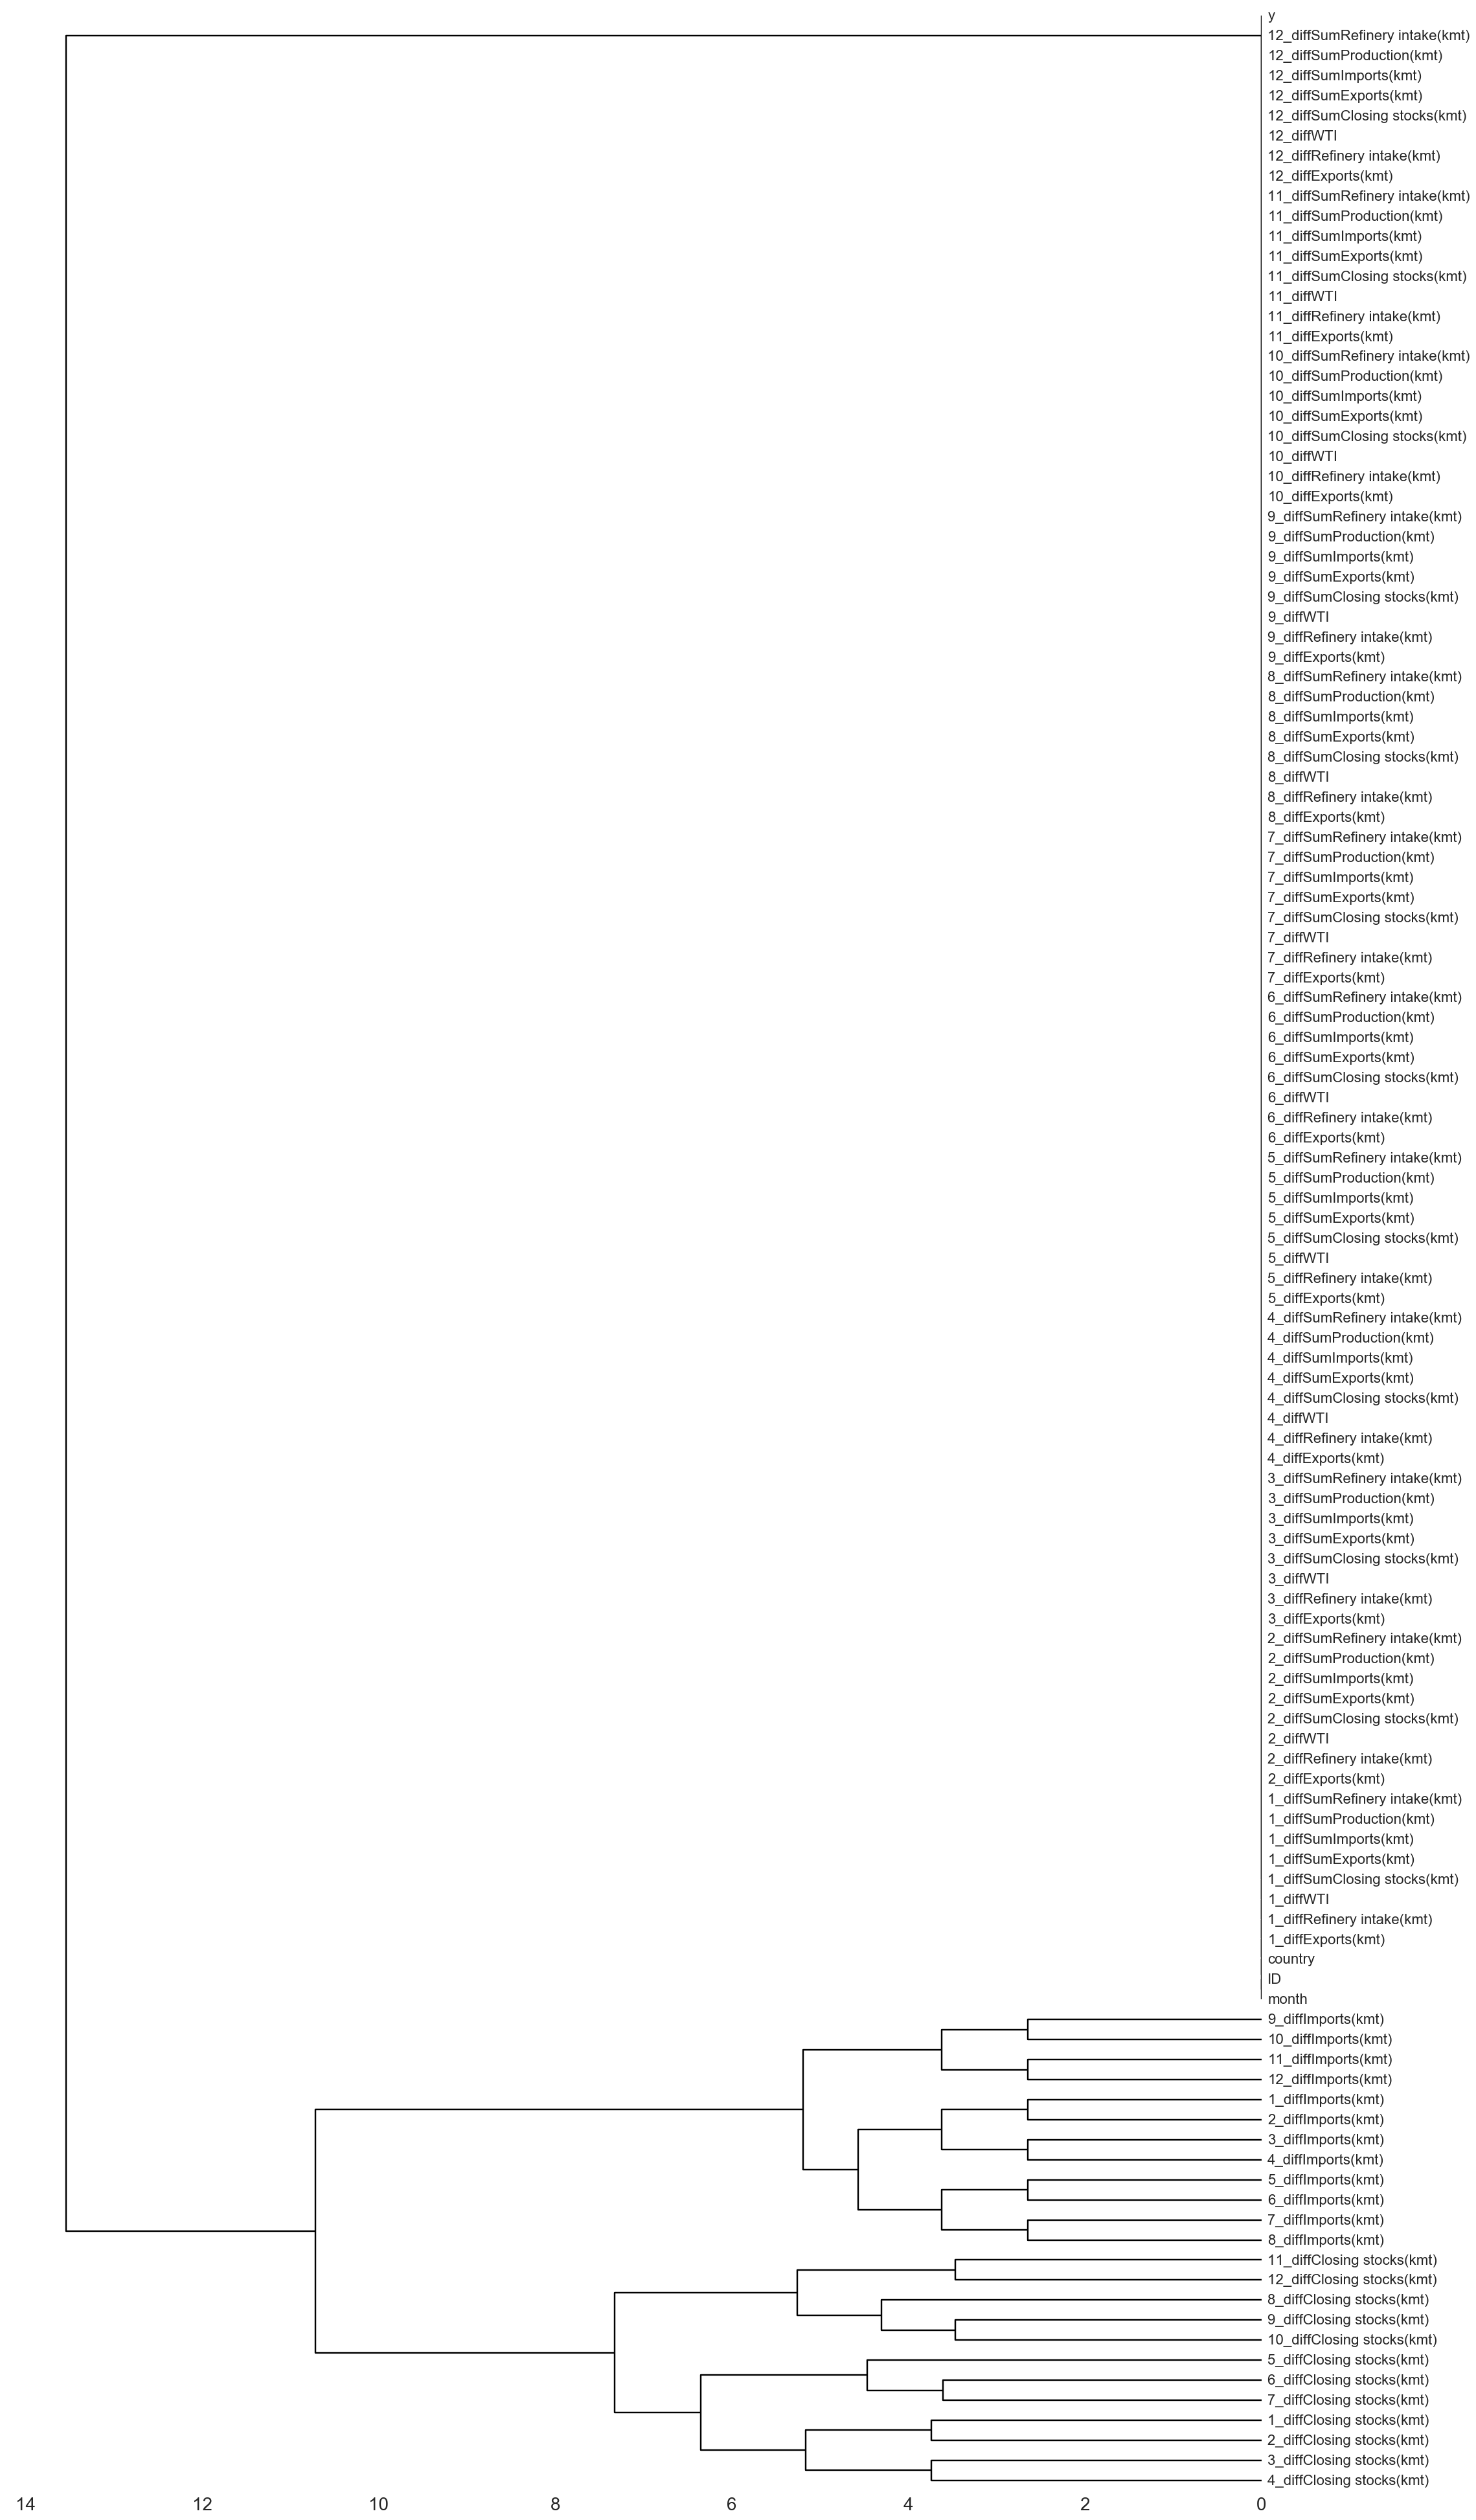

In [127]:
msno.dendrogram(data_train)

### Feature description
The Train and the Test files contain the following features:
- ID: ID of the line that contains 12 months of data of a given country and other information detailed above.
- month: Month index. There is no indication regarding the year of the collect of the data .
- country: Country index. As said above the countries have been anonymized.

And features that are given for every month of the previous year:
- closing stocks(kmt):   Represents the primary stock level at the end of the month within national territories; includes stocks held by importers, refiners, stock holding organisations and governments in Thousand Metric Tons.
- exports(kmt)/Imports(kmt): Amount of Crude Oil having physically crossed the international boundaries, excluding transit trade, international marine and aviation bunkers in Thousand Metric Tons.
- refinery intake(kmt): Total amount of oil observed to have entered the refinery process in Thousand Metric Tons.
- WTI: West Texas Intermediate Price. This value is the close price at the last business day of the month in USD.
- SumClosing stocks(kmt), SumExports(kmt), SumImports(kmt), SumProduction(kmt) and SumRefinery intake(kmt): Sums of previous features over all countries on the same period in Thousand Metric Tons.

The prefix "diff" in columns names means that the columns are the difference between the month value and the value of the previous month. The prefix of the column refers the data record month. For example, the "12_diffExports(kmt)" is the closest value from the trend that we are predicting and "1_diffExports(kmt)" is the farthest value from the trend that we are predicting.
Semicolon is the columns separator used in all provided files.

The TrainOutput file contains the Target for each "ID", where the target is either:
- 1: if the production goes up for the next quarter.
- 0: if the production goes down for the next quarter.

Submission file has to be a CSV file with the following format (The first line of the file is the header):
"ID"; "Target" 
"ID10160"; xxxx 
... 
"ID12159"; xxxx
Where xxx is a probability (number between 0 and 1 included), for instance 0.5. 

The metric used for this challenge is the AUC (area under the ROC curve)

## Goal
The objective of this challenge is to predict the probability of increase of Crude Oil production per quarter per country based on several indicators collected during the previous year.

To this end, we have a dataset of 123 explaining features, with :

Therefore we are dealing with an imbalanced class problem, and will keep that in mind for the modelization part.

In [ ]:
data_train["y"].value_counts().plot(kind="pie", title="Y share")

In [18]:
np.transpose(data_train.describe())

count        mean           std         min  \
month                           10159.0    6.473866      3.438871      1.0000   
country                         10159.0   38.442268     21.923267      1.0000   
1_diffClosing stocks(kmt)        9898.0    0.517624    761.965975 -39400.0000   
1_diffExports(kmt)              10159.0    3.772813    543.533615 -10200.0000   
1_diffImports(kmt)              10008.0    1.581989    677.256249 -22159.0000   
1_diffRefinery intake(kmt)      10159.0    3.531208   1874.477959 -73610.7409   
1_diffWTI                       10159.0    0.567494      6.699482    -32.6000   
1_diffSumClosing stocks(kmt)    10159.0   57.443267   6016.337184 -33236.7385   
1_diffSumExports(kmt)           10159.0  302.377589   7961.169490 -16196.6495   
1_diffSumImports(kmt)           10159.0  129.356949   9111.023583 -26272.2875   
1_diffSumProduction(kmt)        10159.0  387.809522  12819.753888 -28046.1357   
1_diffSumRefinery intake(kmt)   10159.0  305.419239  20404.435382 -71439.4140   
2_diffClosing stocks(kmt)        9902.0    0.742556    761.724351 -39400.0000   
2_diffExports(kmt)              10159.0    4.959824    543.609346 -10200.0000   
2_diffImports(kmt)              10011.0    2.777854    677.185134 -22159.0000   
2_diffRefinery intake(kmt)      10159.0    6.552034   1874.895261 -73610.7409   
2_diffWTI                       10159.0    0.543507      6.709918    -32.6000   
2_diffSumClosing stocks(kmt)    10159.0   81.652426   6022.238313 -33236.7385   
2_diffSumExports(kmt)           10159.0  371.192552   7964.623137 -16196.6495   
2_diffSumImports(kmt)           10159.0  212.352611   9104.624705 -26272.2875   
2_diffSumProduction(kmt)        10159.0  597.579487  12705.850266 -28046.1357   
2_diffSumRefinery intake(kmt)   10159.0  476.154170  20349.593763 -71439.4140   
3_diffClosing stocks(kmt)        9906.0    0.756207    760.428316 -39400.0000   
3_diffExports(kmt)              10159.0    3.266168    540.212842 -10200.0000   
3_diffImports(kmt)              10014.0    2.085293    675.497710 -22159.0000   
3_diffRefinery intake(kmt)      10159.0    4.444096   1873.822198 -73610.7409   
3_diffWTI                       10159.0    0.494593      6.706375    -32.6000   
3_diffSumClosing stocks(kmt)    10159.0   67.252350   6016.557513 -33236.7385   
3_diffSumExports(kmt)           10159.0  262.106381   7837.376082 -16196.6495   
3_diffSumImports(kmt)           10159.0  150.980411   9066.522039 -26272.2875   
...                                 ...         ...           ...         ...   
10_diffExports(kmt)             10159.0    3.262001    538.739515 -10200.0000   
10_diffImports(kmt)             10035.0    1.666753    680.373585 -22159.0000   
10_diffRefinery intake(kmt)     10159.0    5.800392   1876.392698 -73610.7409   
10_diffWTI                      10159.0    0.517833      6.806354    -32.6000   
10_diffSumClosing stocks(kmt)   10159.0    4.234261   6039.745140 -33236.7385   
10_diffSumExports(kmt)          10159.0  240.206214   7901.891816 -16196.6495   
10_diffSumImports(kmt)          10159.0  125.844331   9148.828479 -26272.2875   
10_diffSumProduction(kmt)       10159.0  394.037004  12696.513769 -28046.1357   
10_diffSumRefinery intake(kmt)  10159.0  469.349083  20383.171695 -71439.4140   
11_diffClosing stocks(kmt)       9935.0   -0.098057    757.647774 -39400.0000   
11_diffExports(kmt)             10159.0    3.023665    541.345419 -10200.0000   
11_diffImports(kmt)             10038.0    1.906747    679.968729 -22159.0000   
11_diffRefinery intake(kmt)     10159.0    6.342198   1876.418096 -73610.7409   
11_diffWTI                      10159.0    0.529798      6.810870    -32.6000   
11_diffSumClosing stocks(kmt)   10159.0   19.068961   6039.385624 -33236.7385   
11_diffSumExports(kmt)          10159.0  208.394996   7882.452268 -16196.6495   
11_diffSumImports(kmt)          10159.0  137.001353   9157.467835 -26272.2875   
11_diffSumProduction(kmt)       10159.0  437.661116  12706.141011

## Vizualization

CPU times: user 11.9 s, sys: 239 ms, total: 12.1 s
Wall time: 13 s


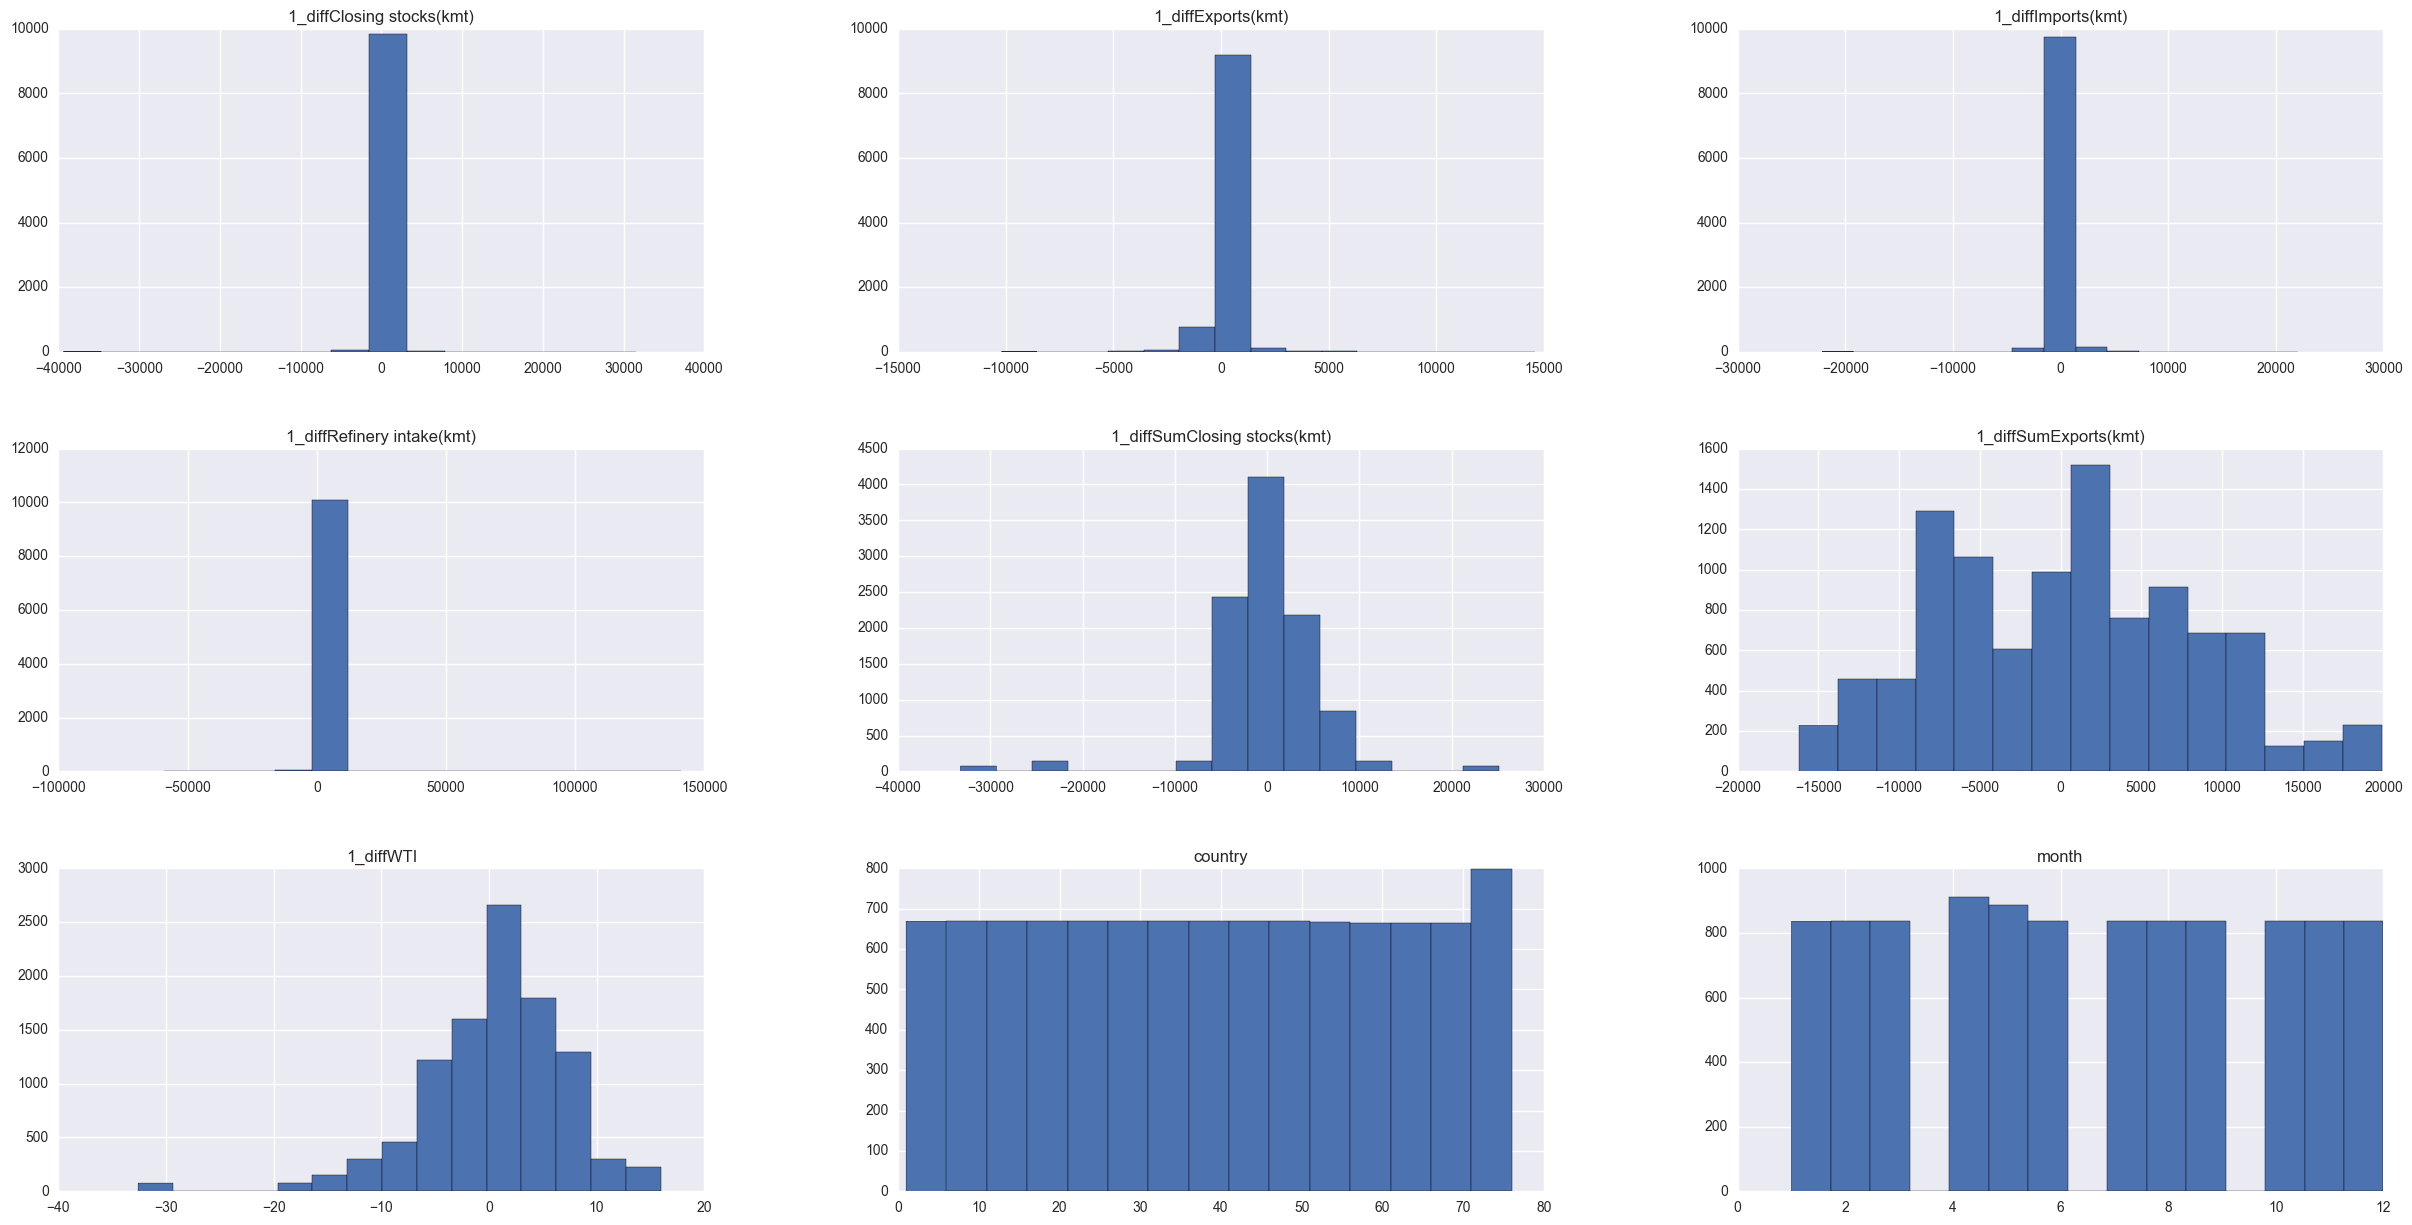

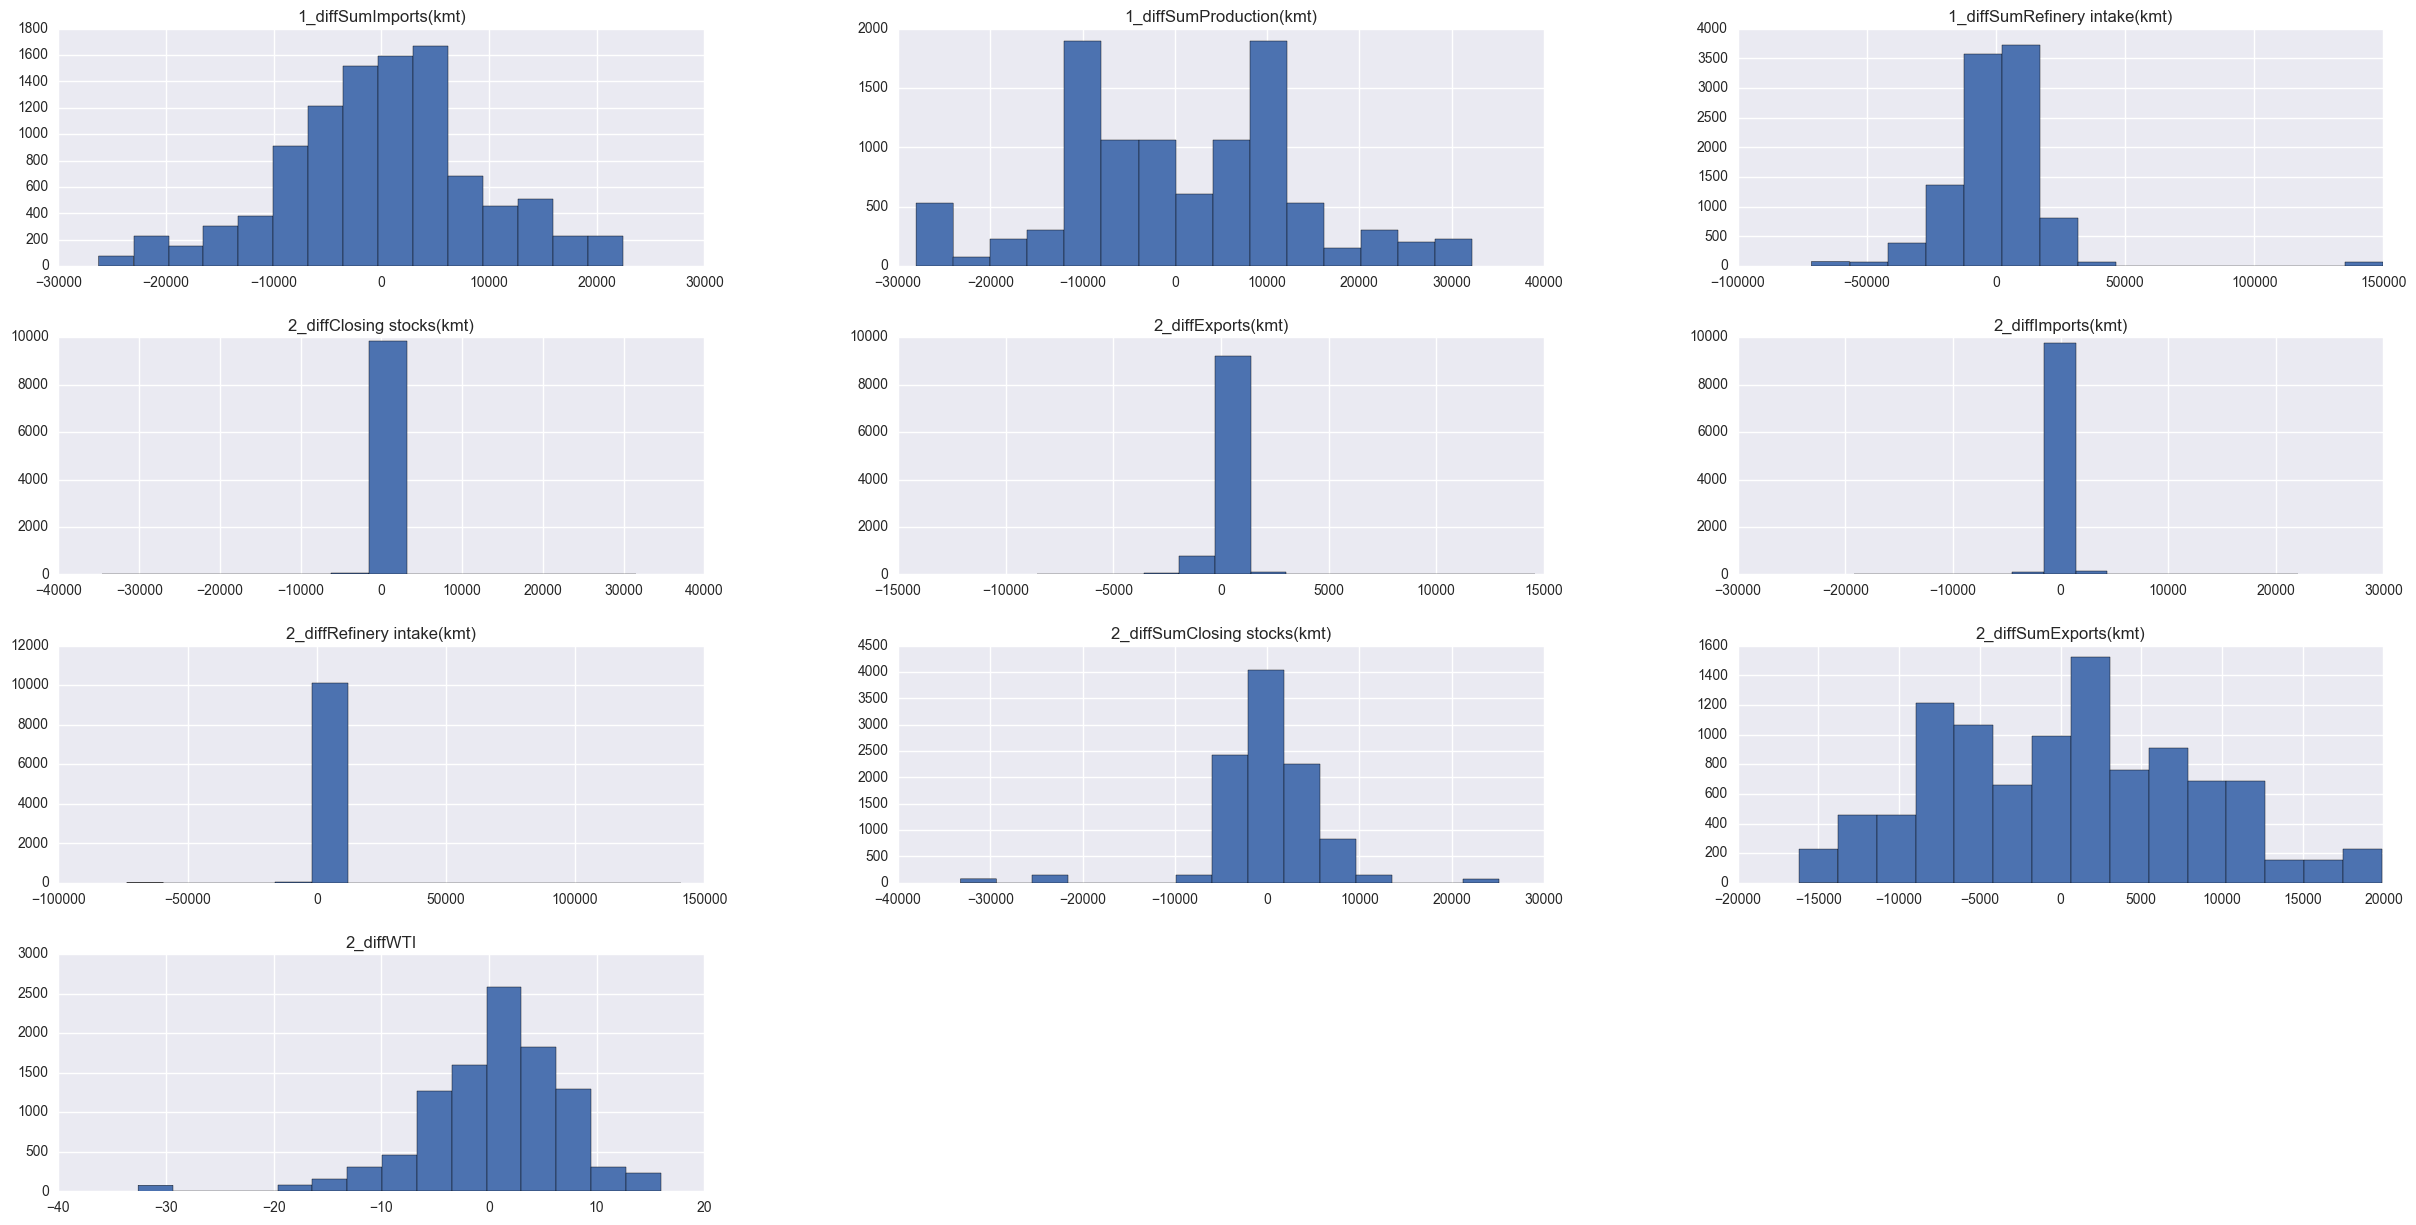

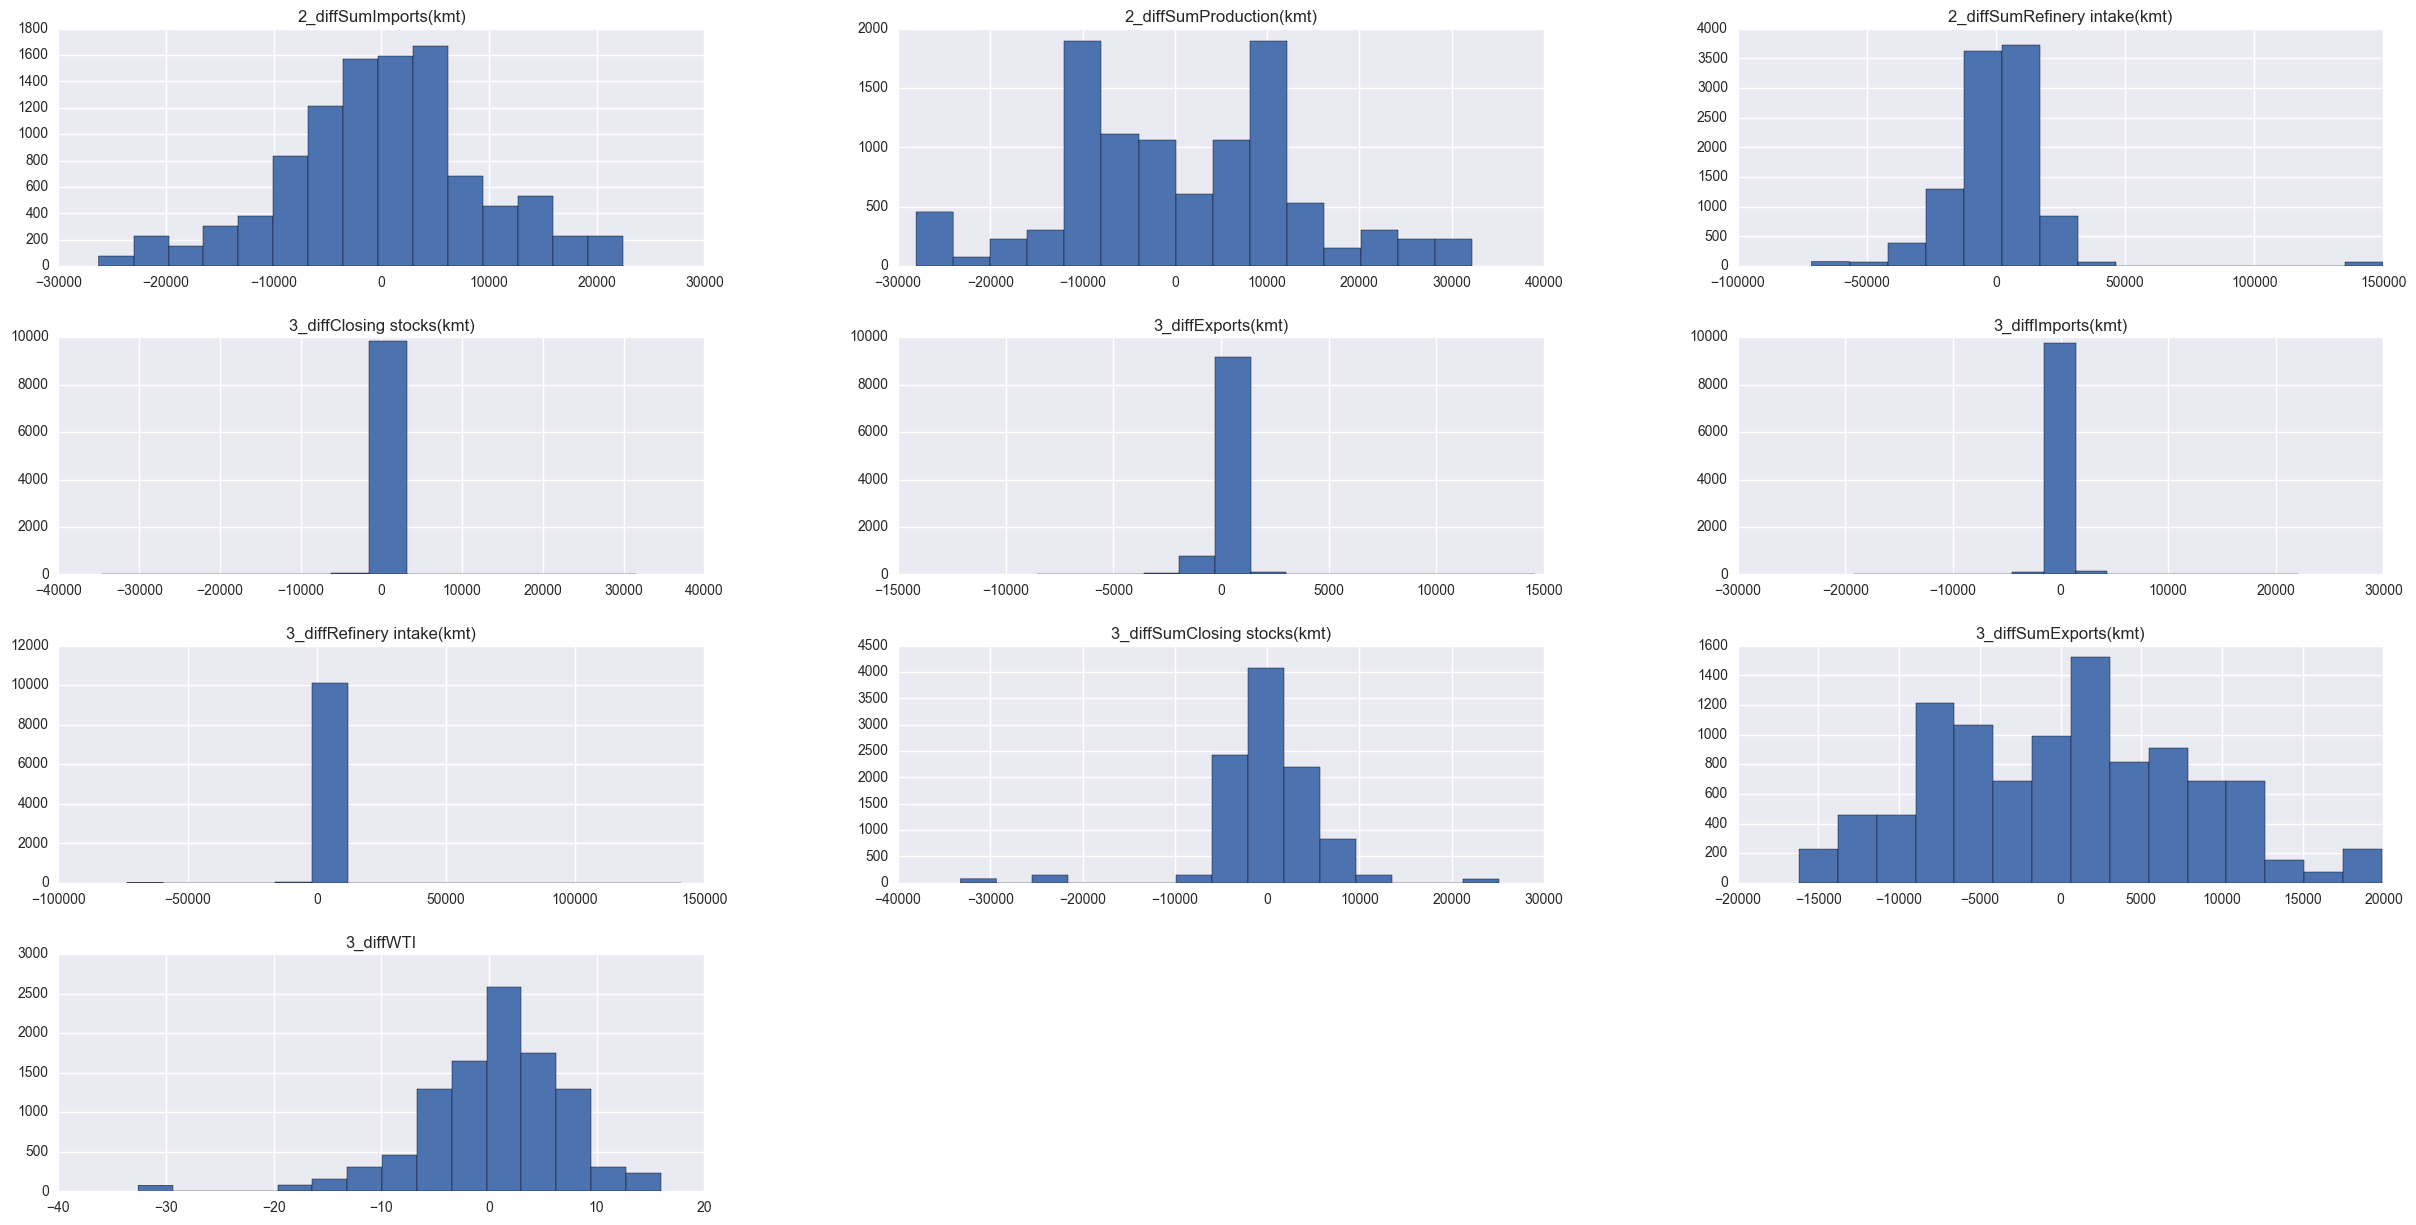

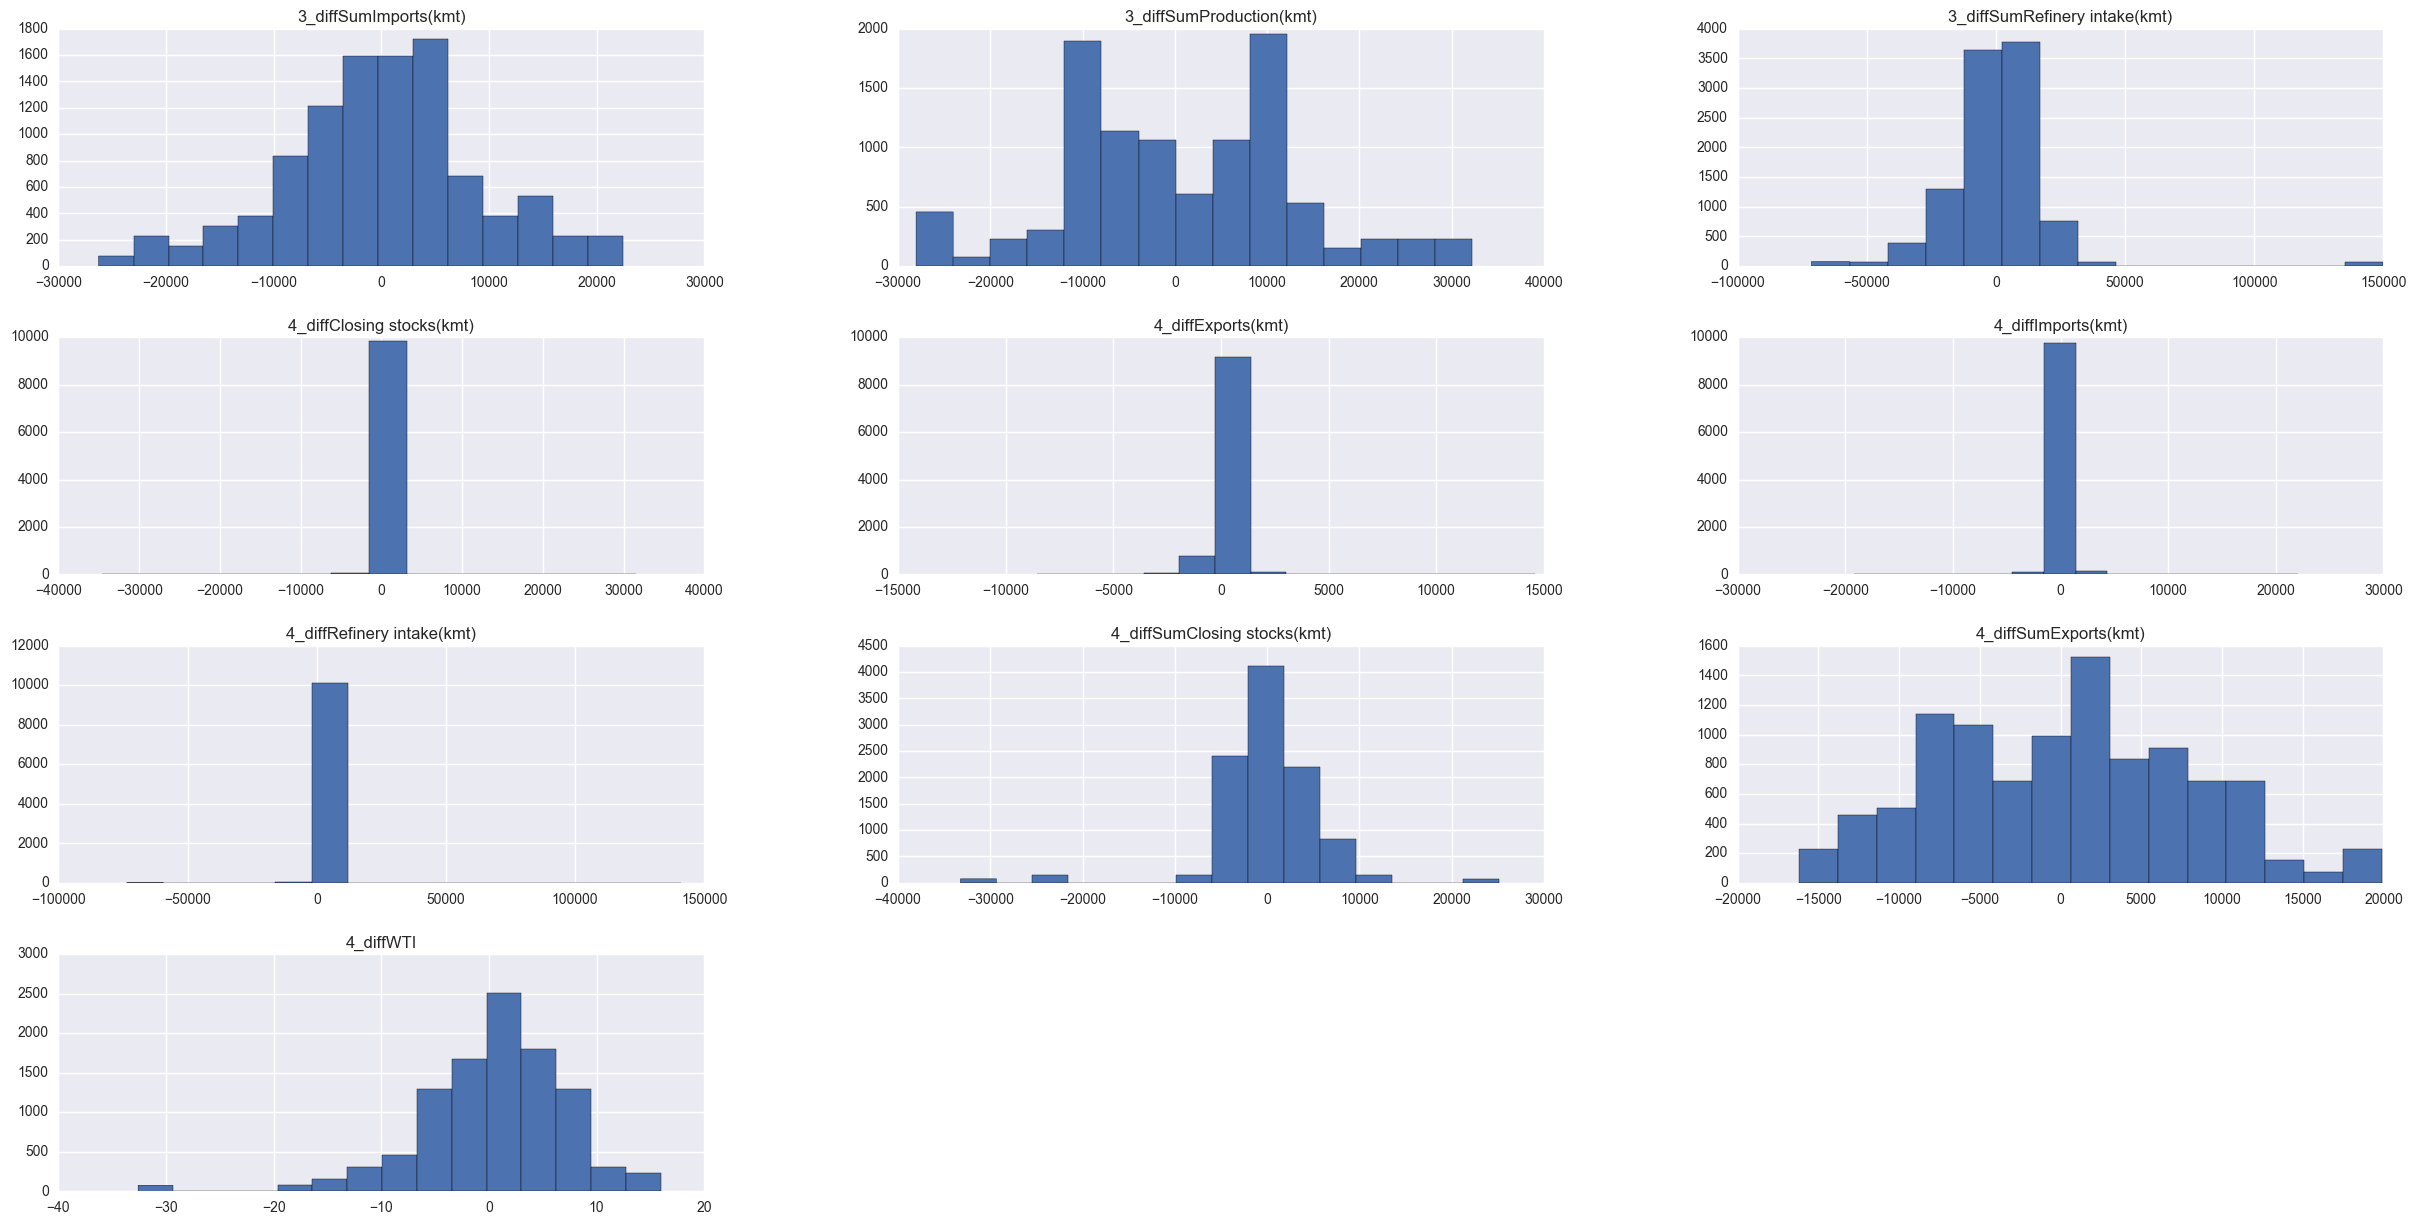

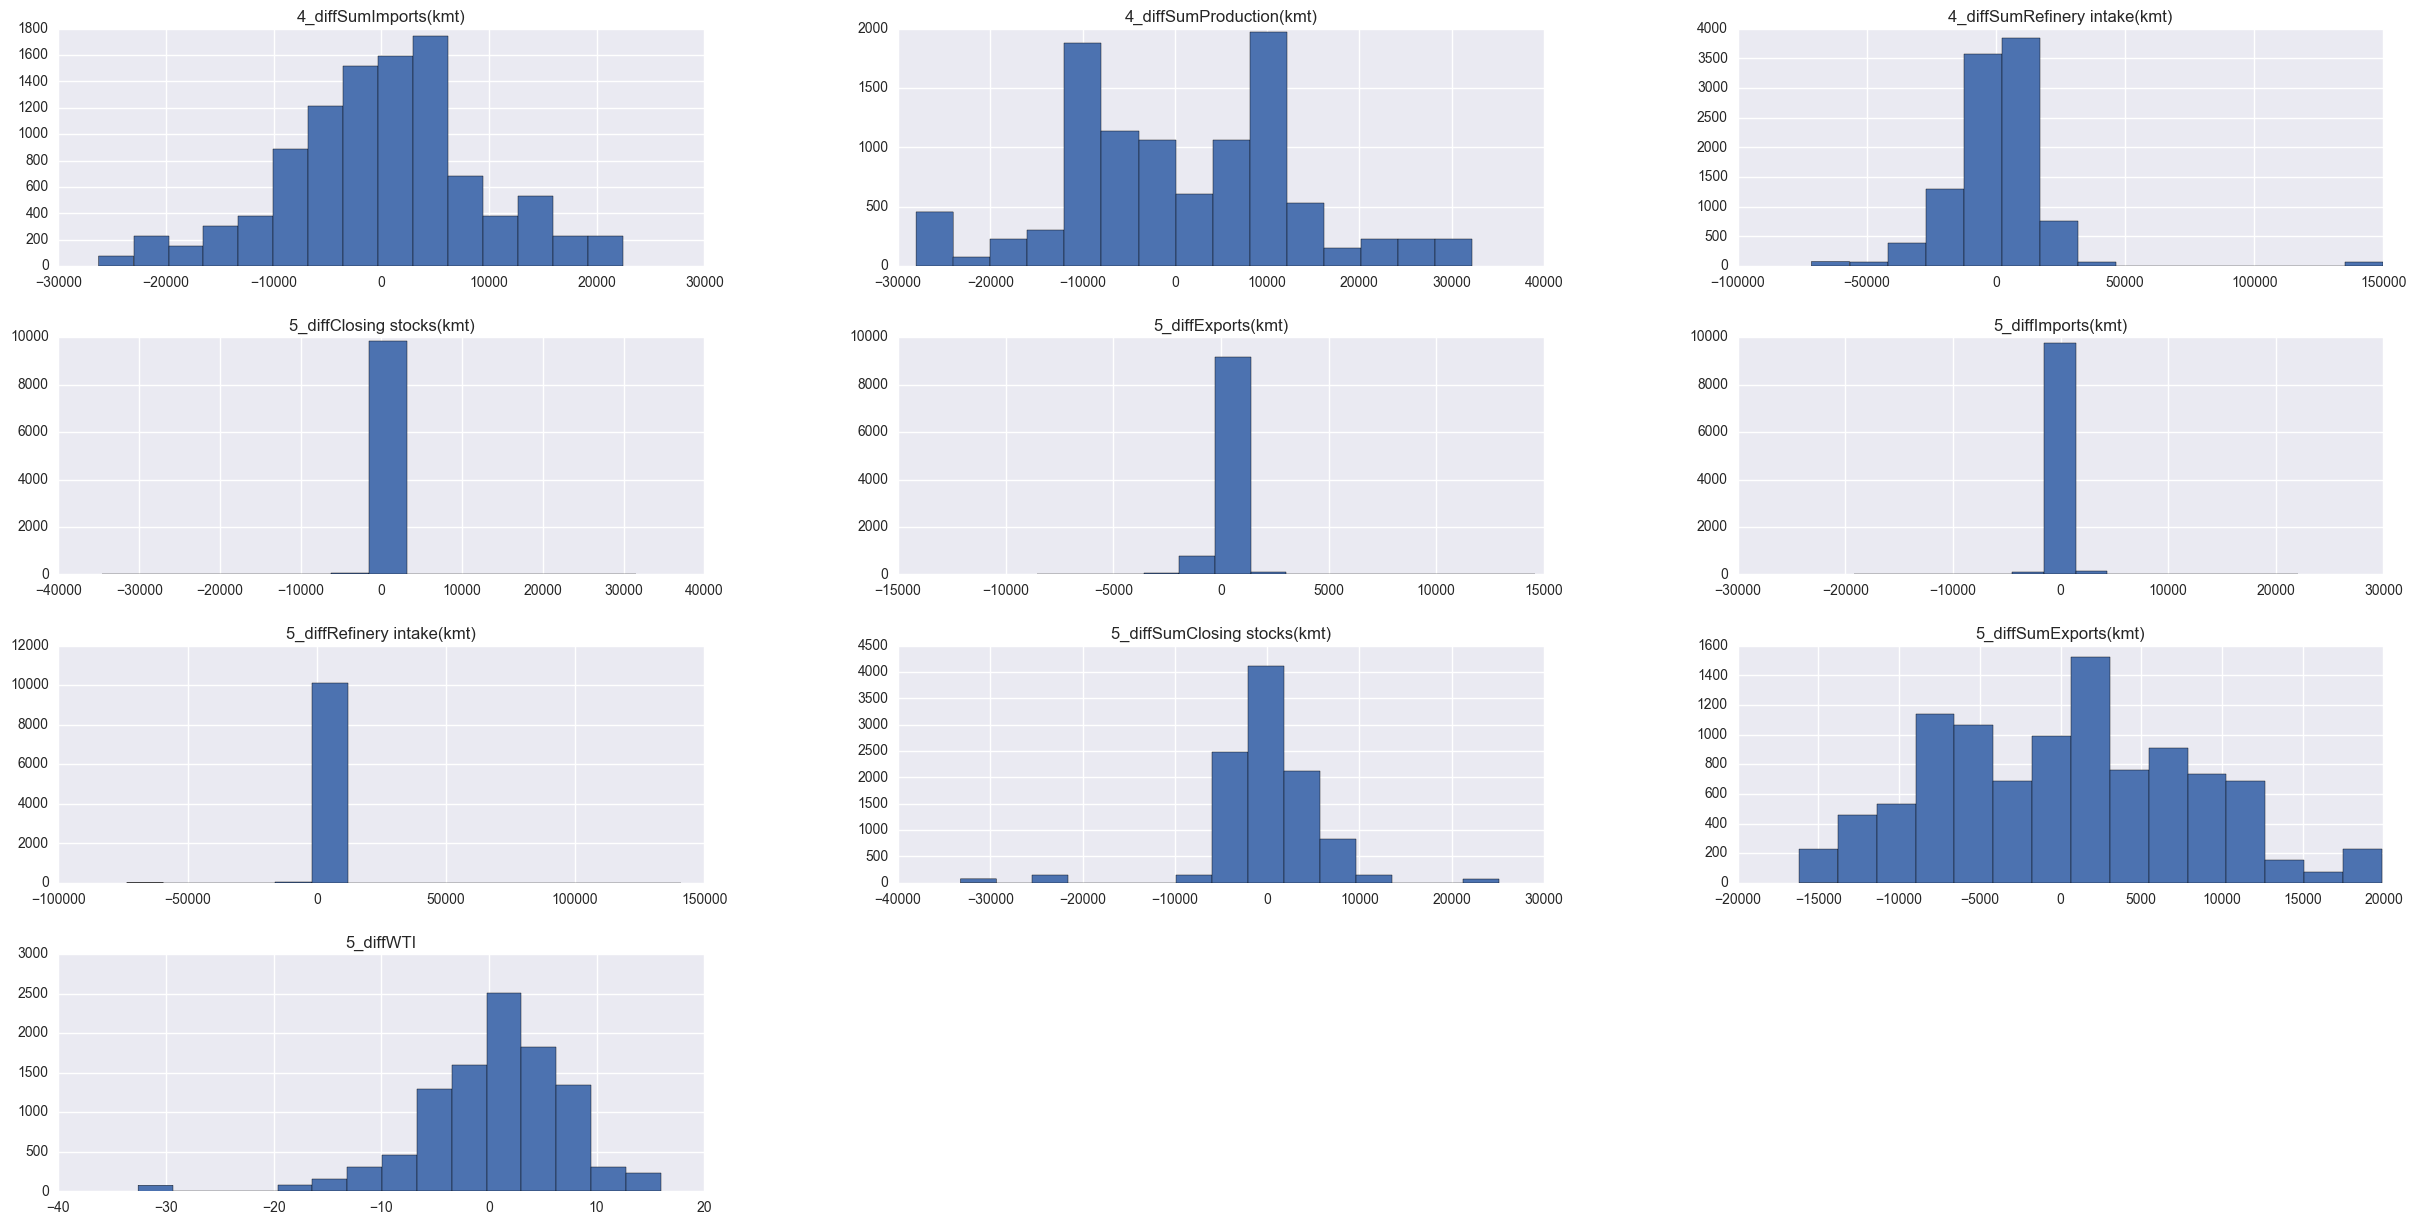

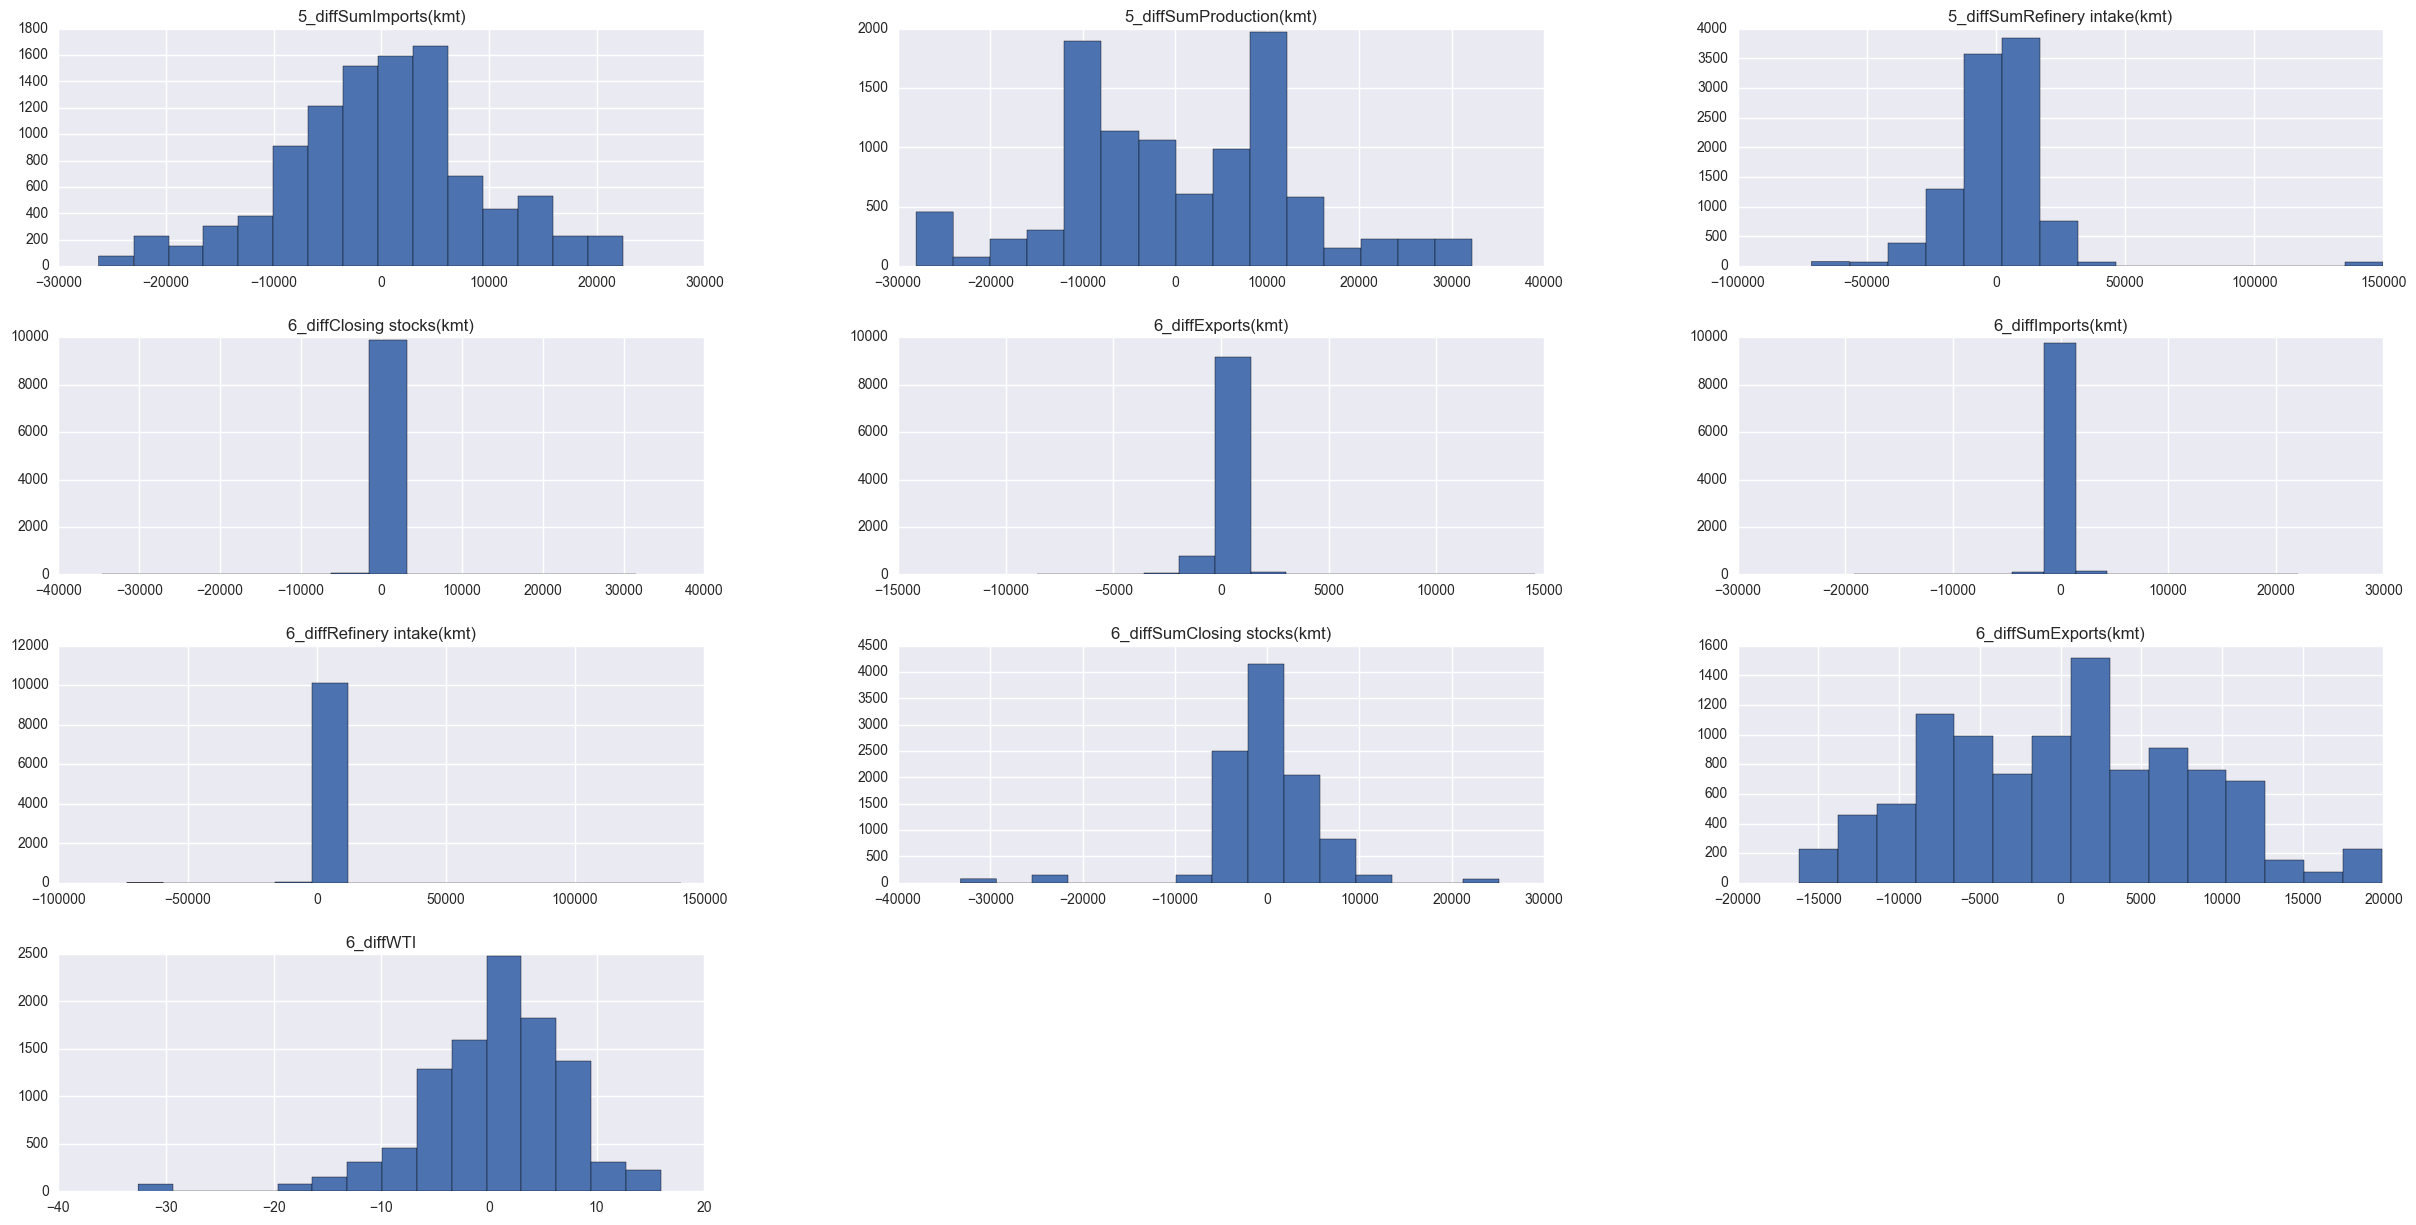

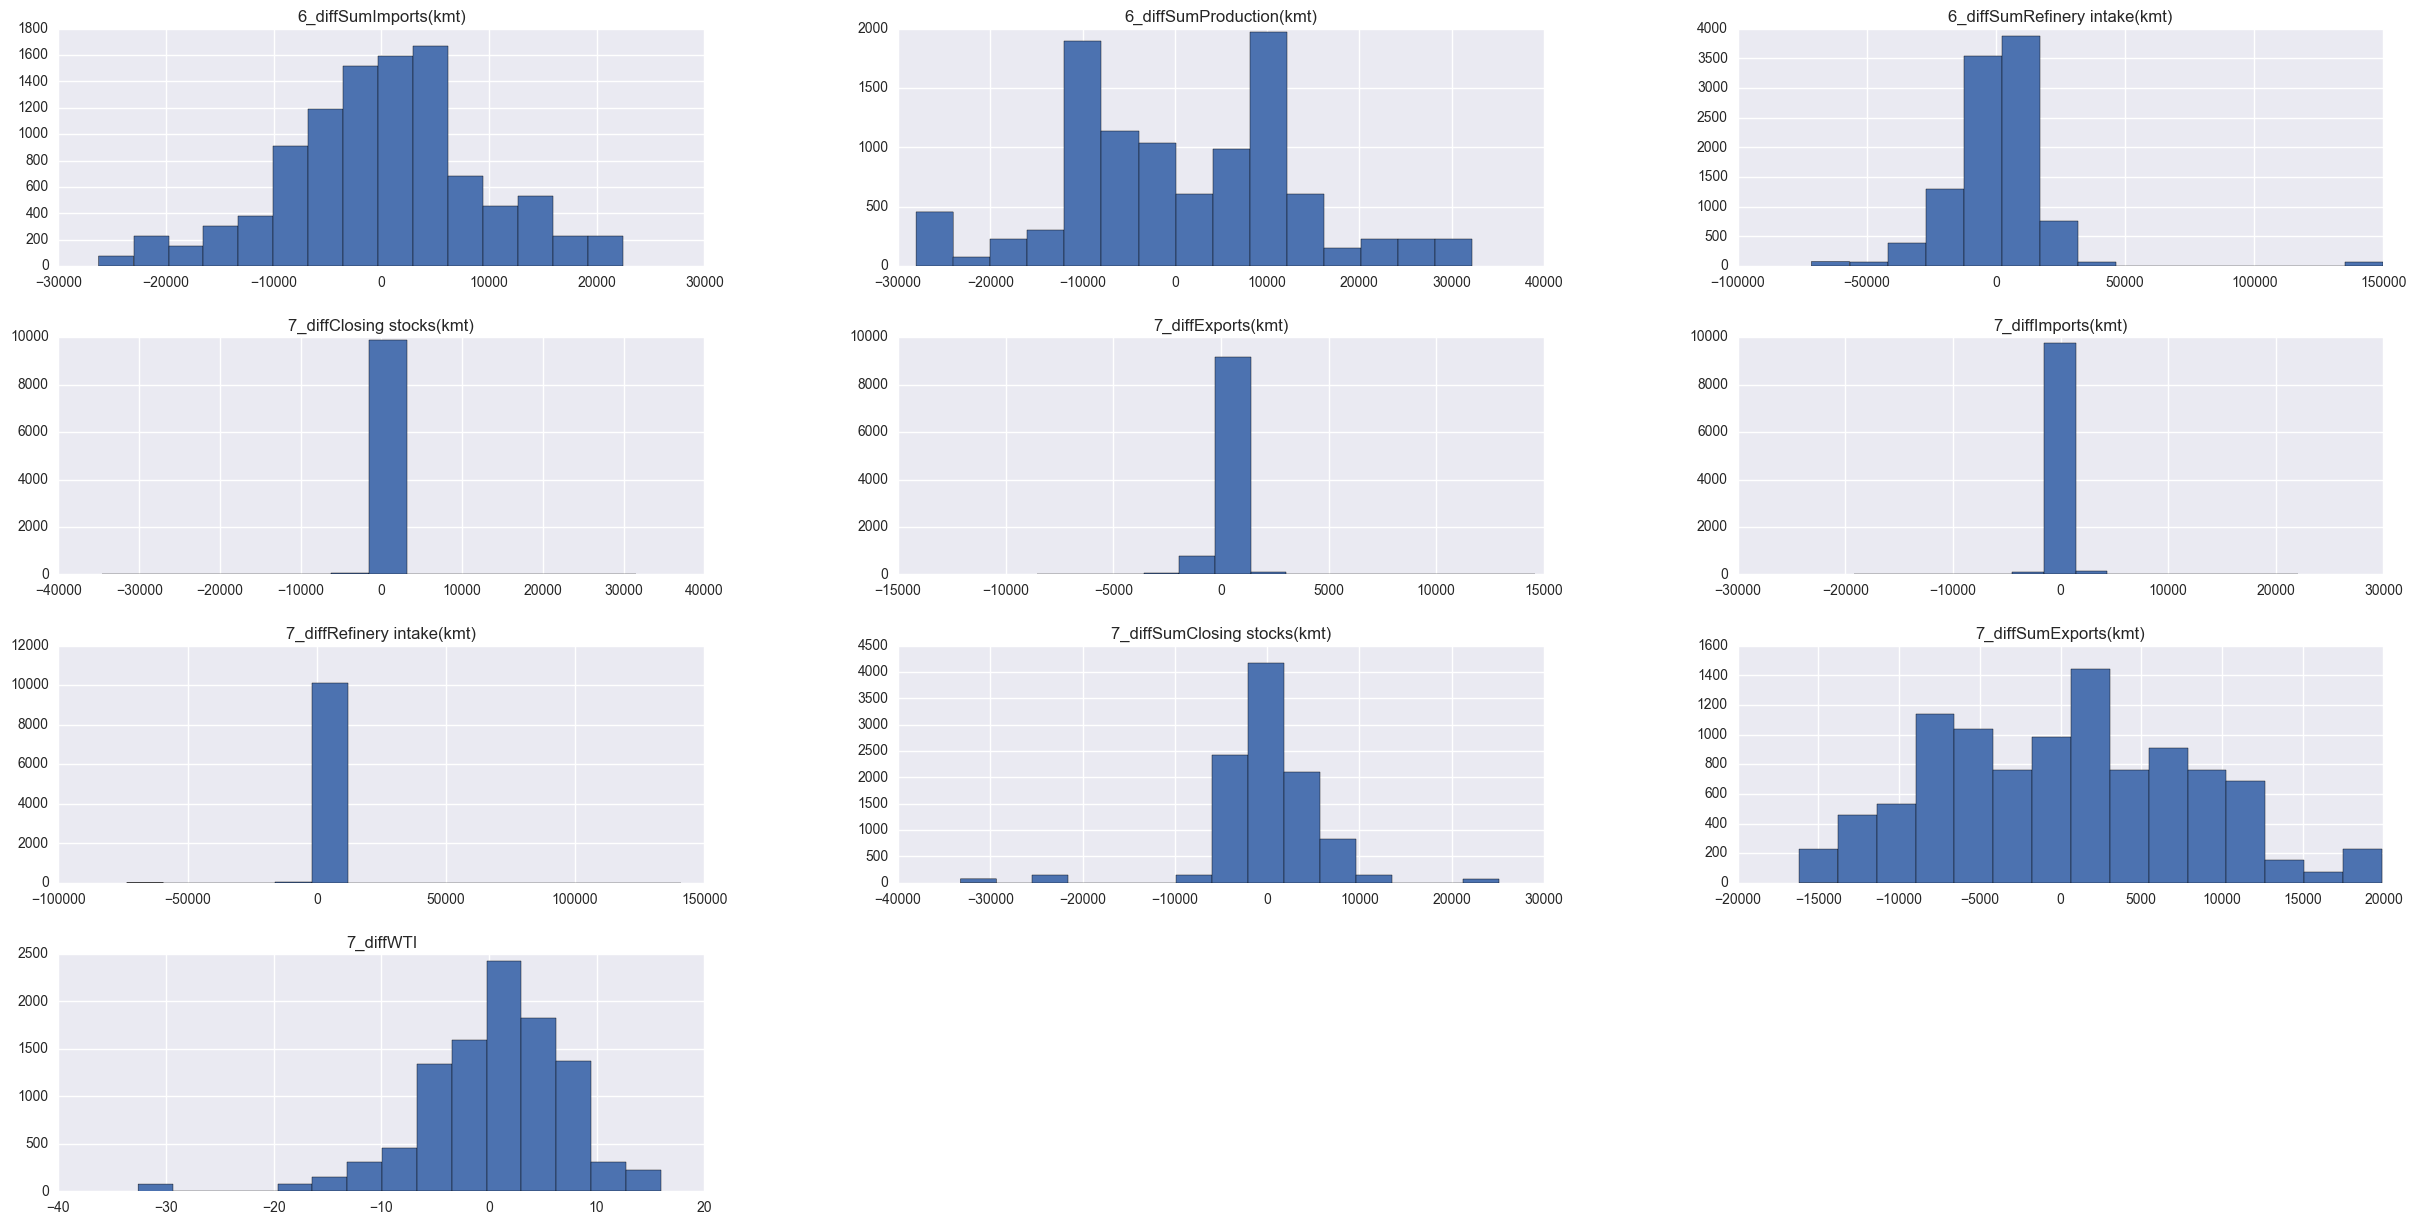

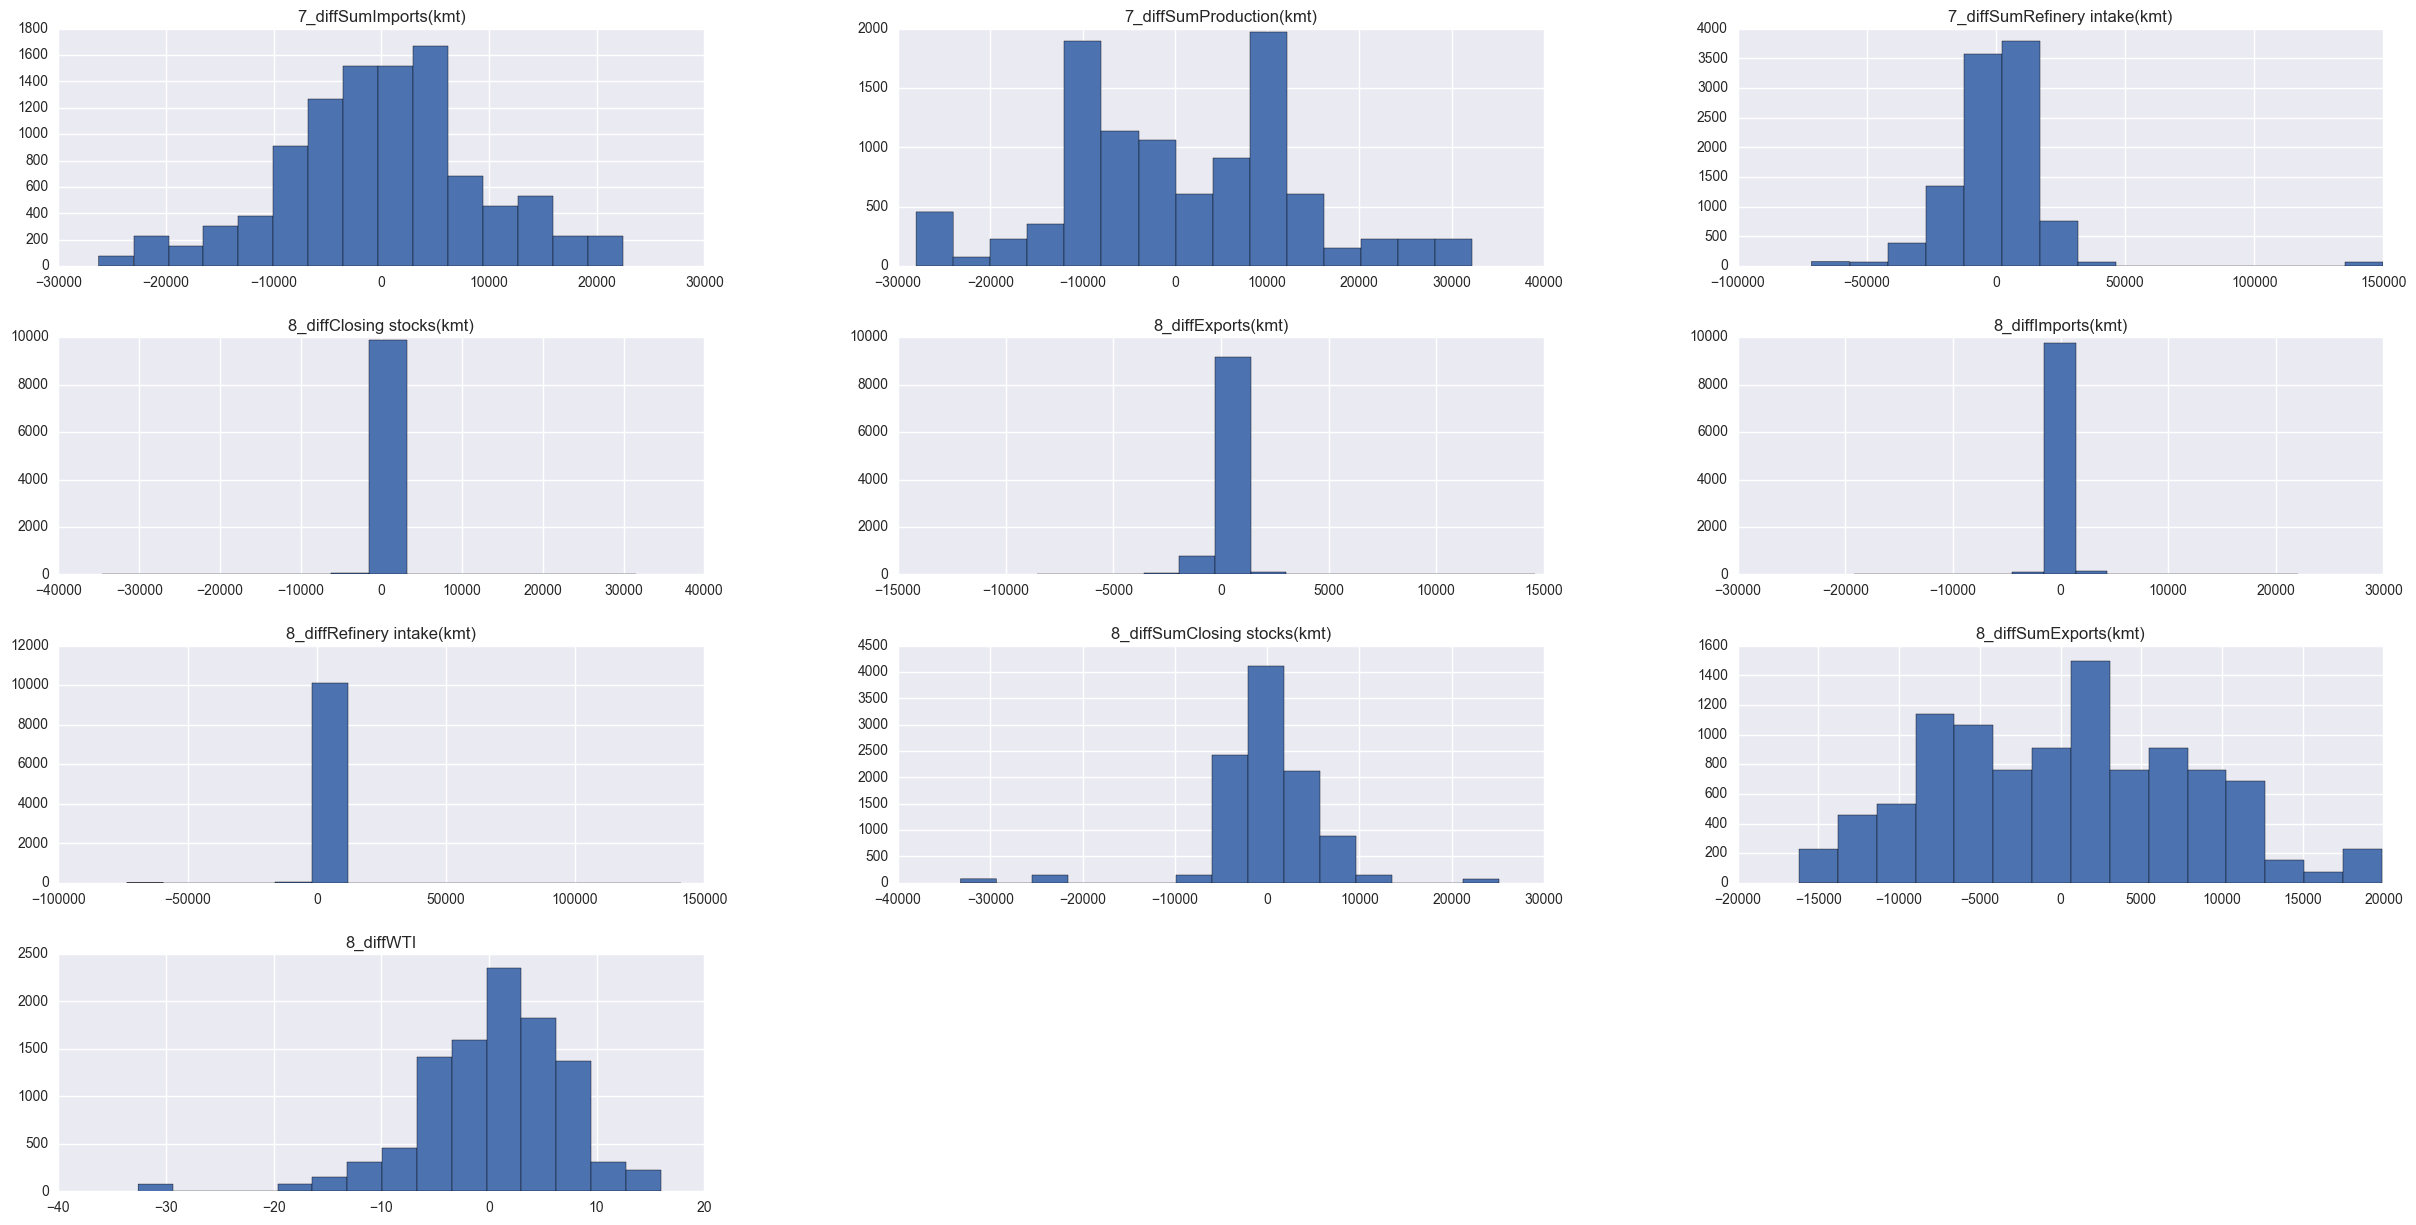

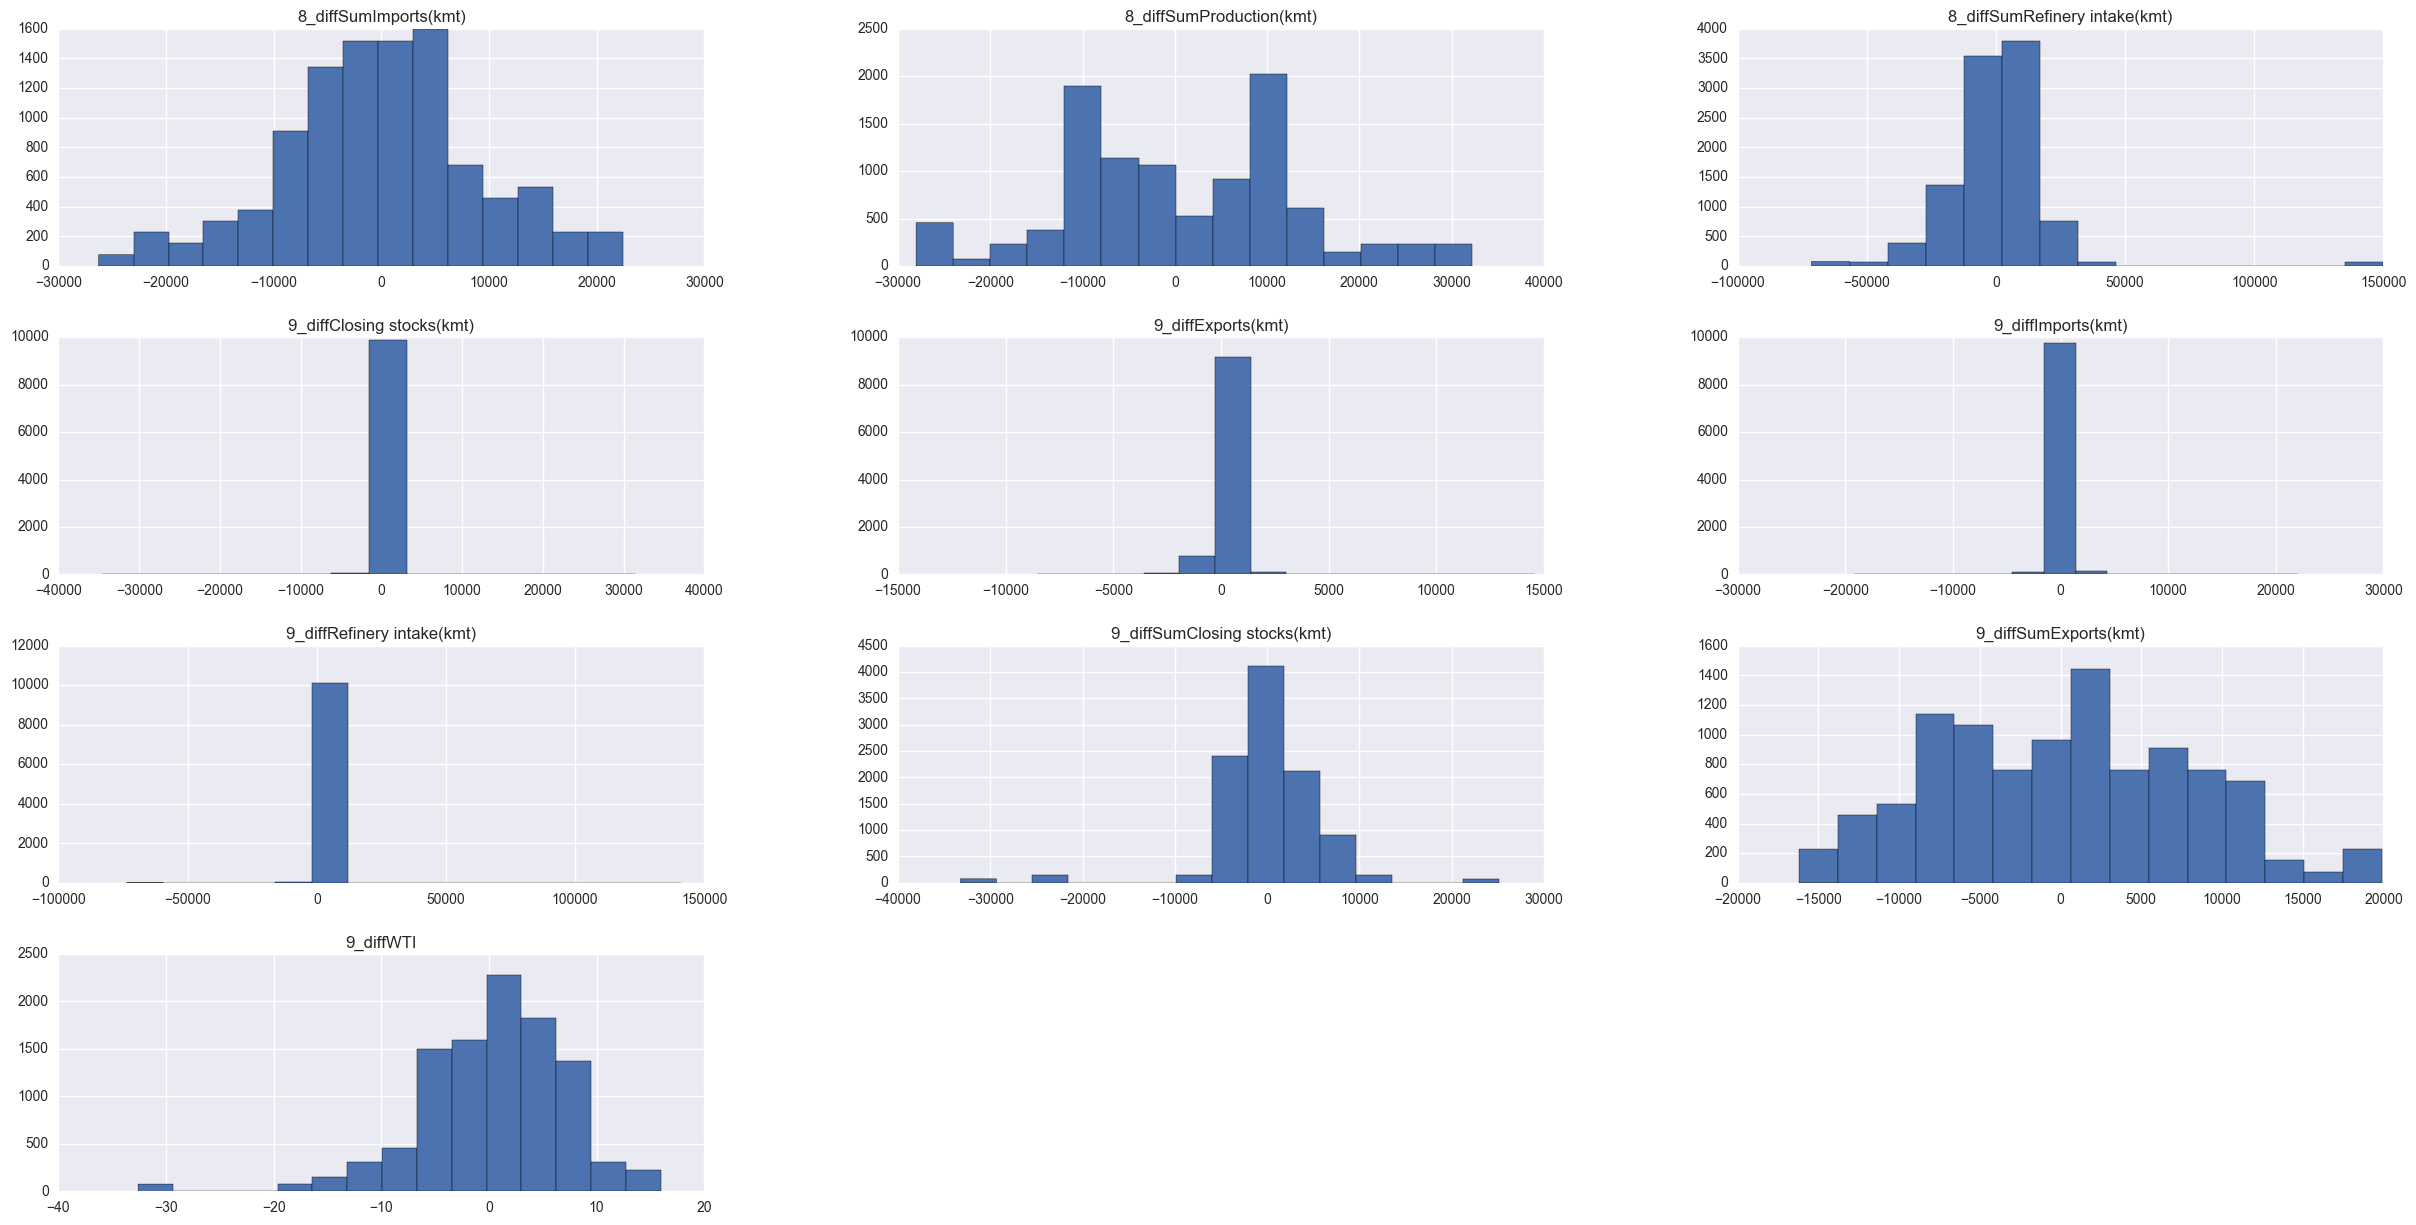

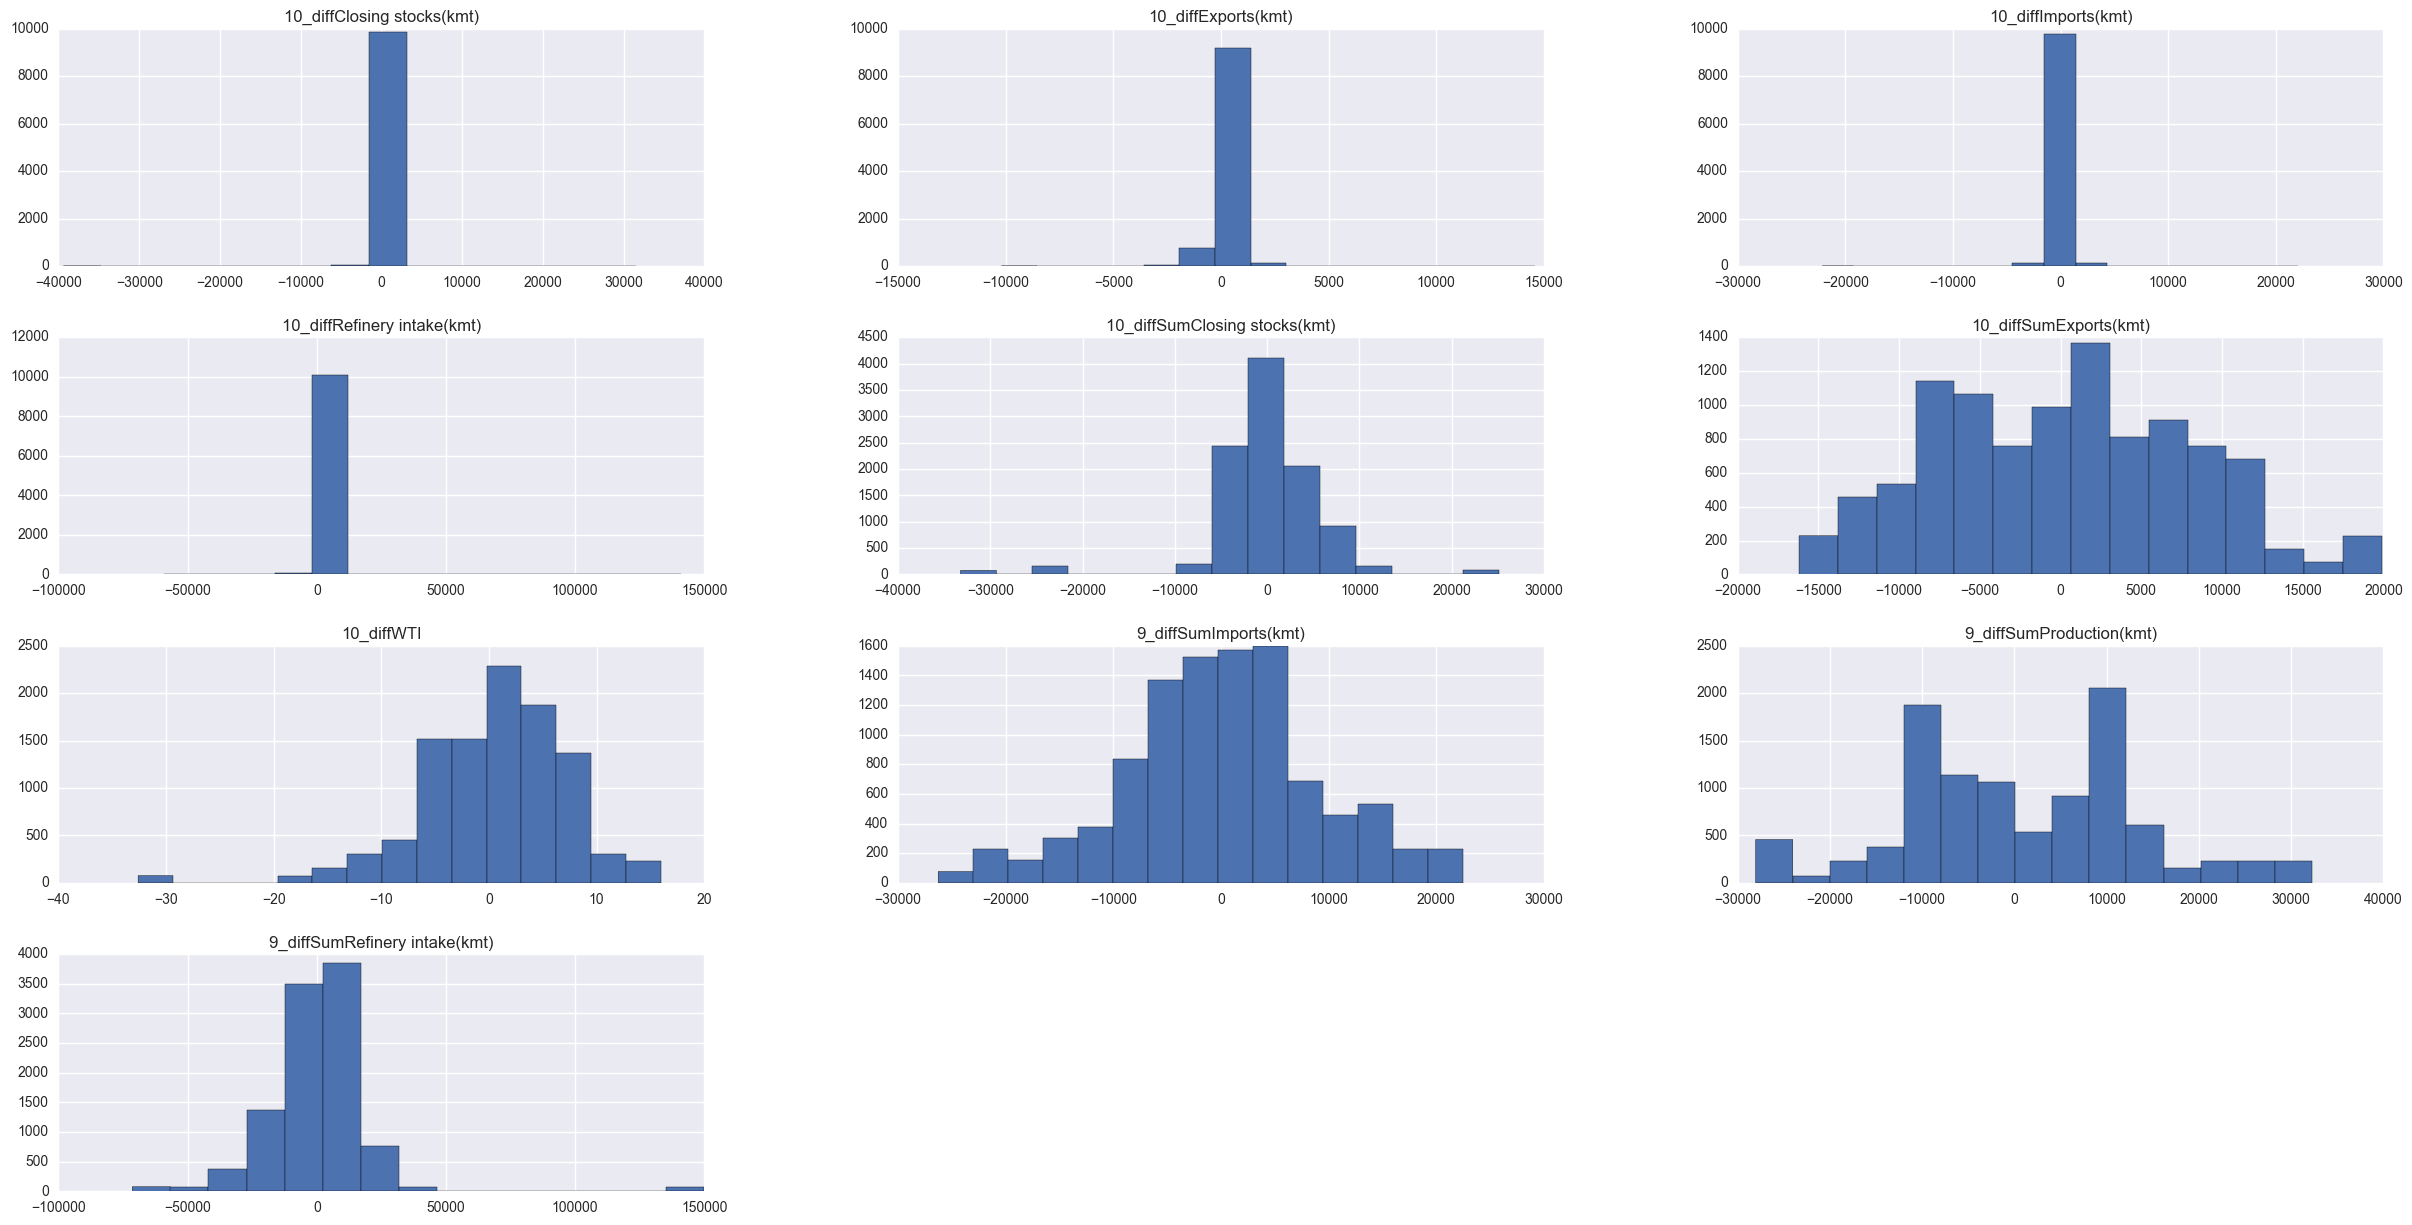

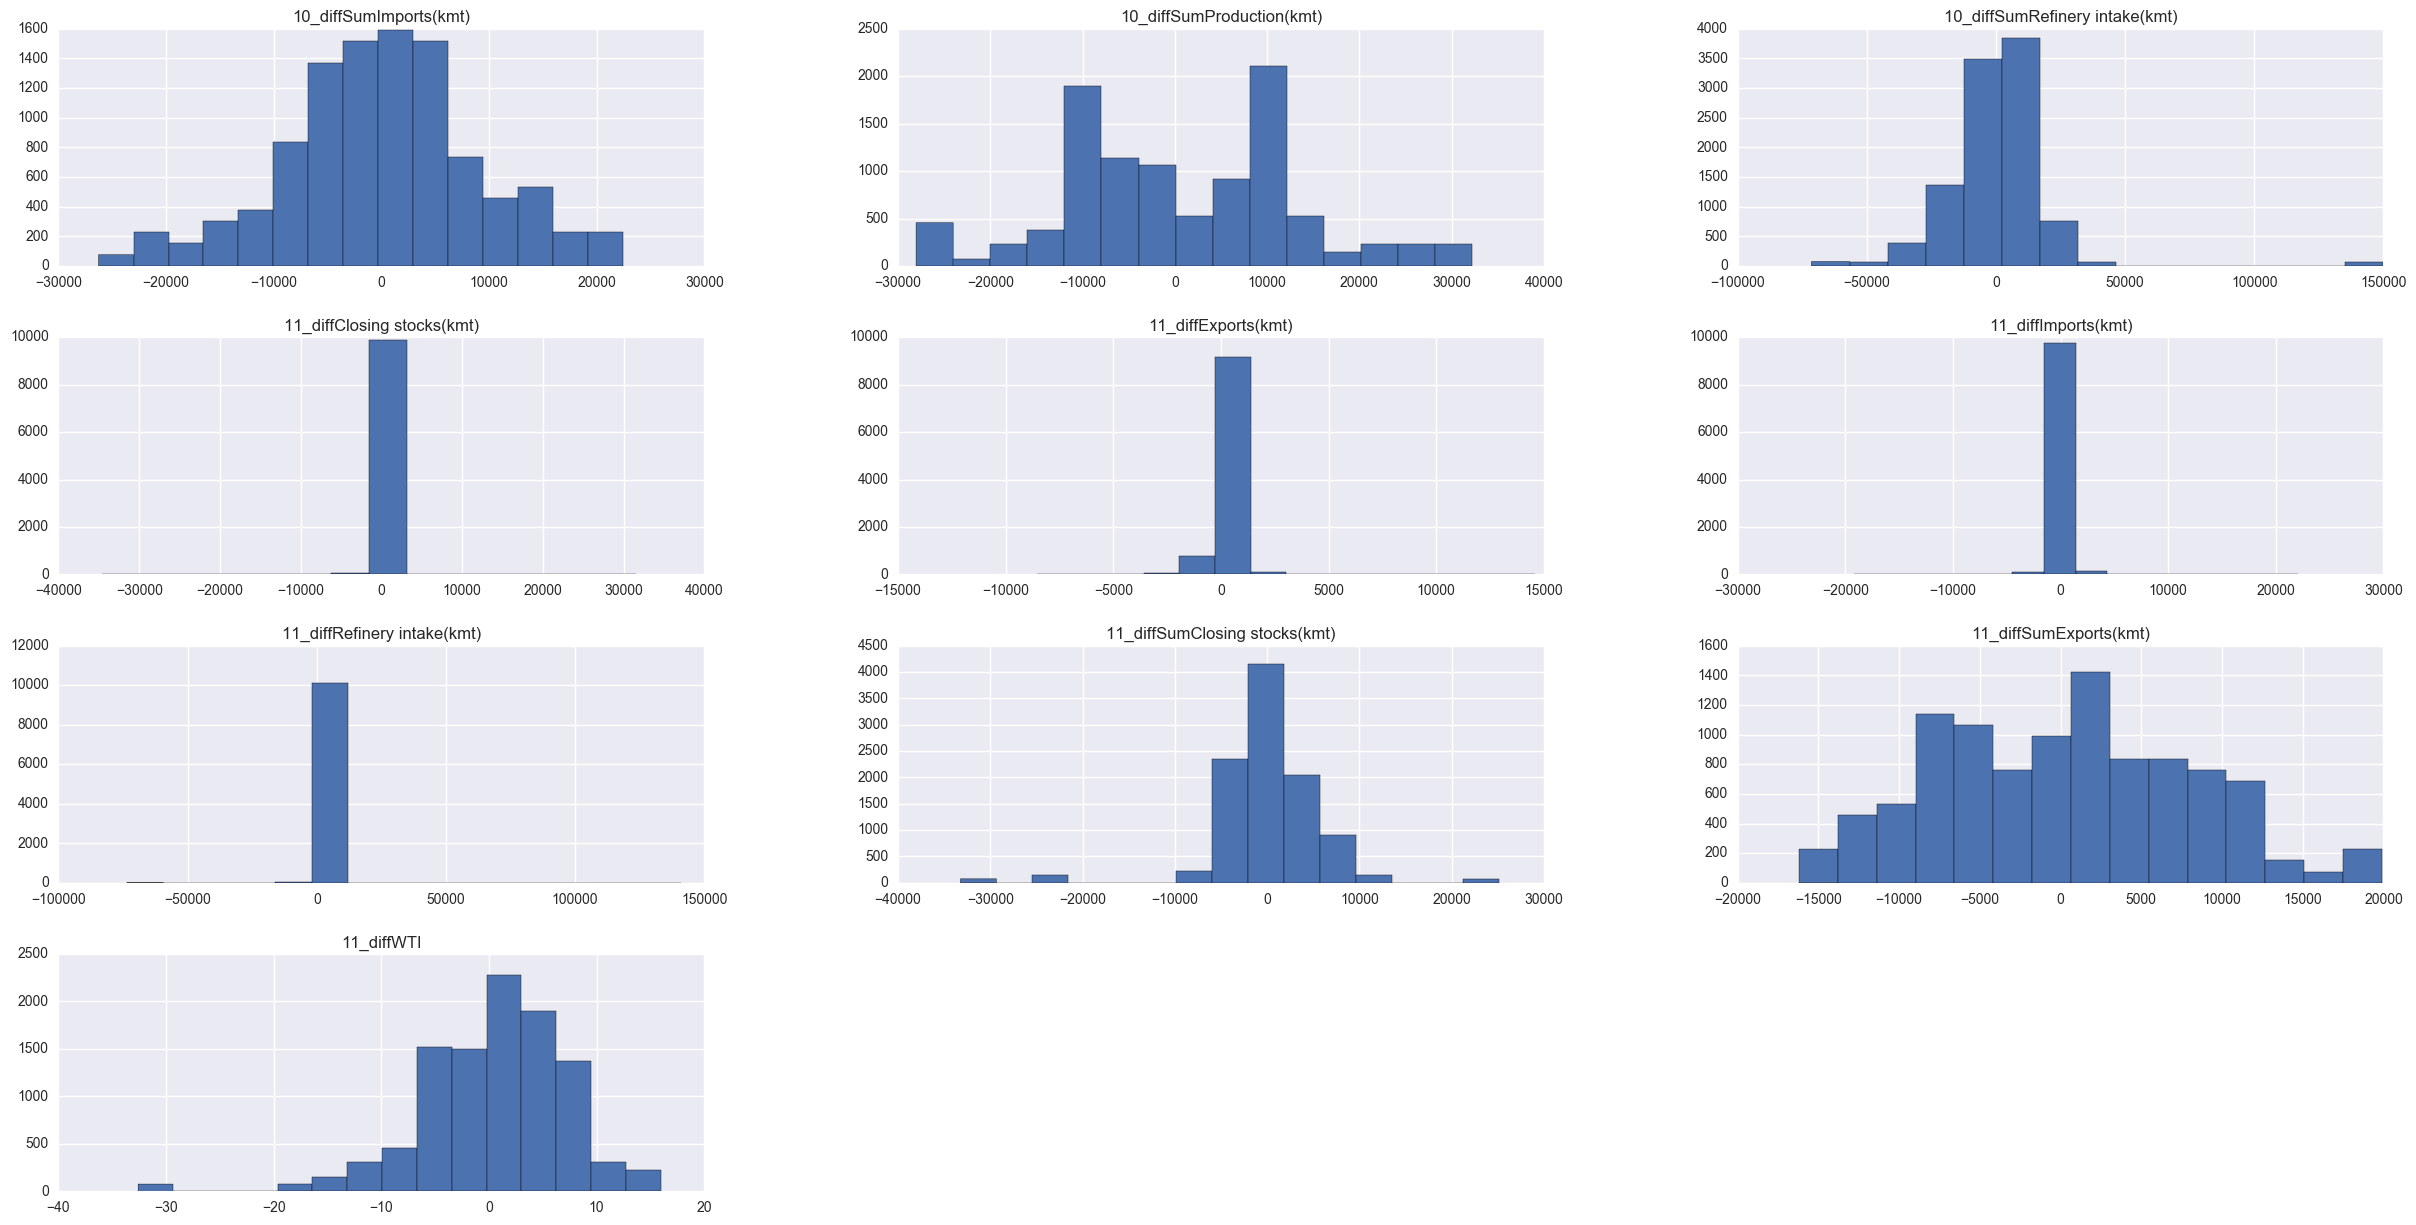

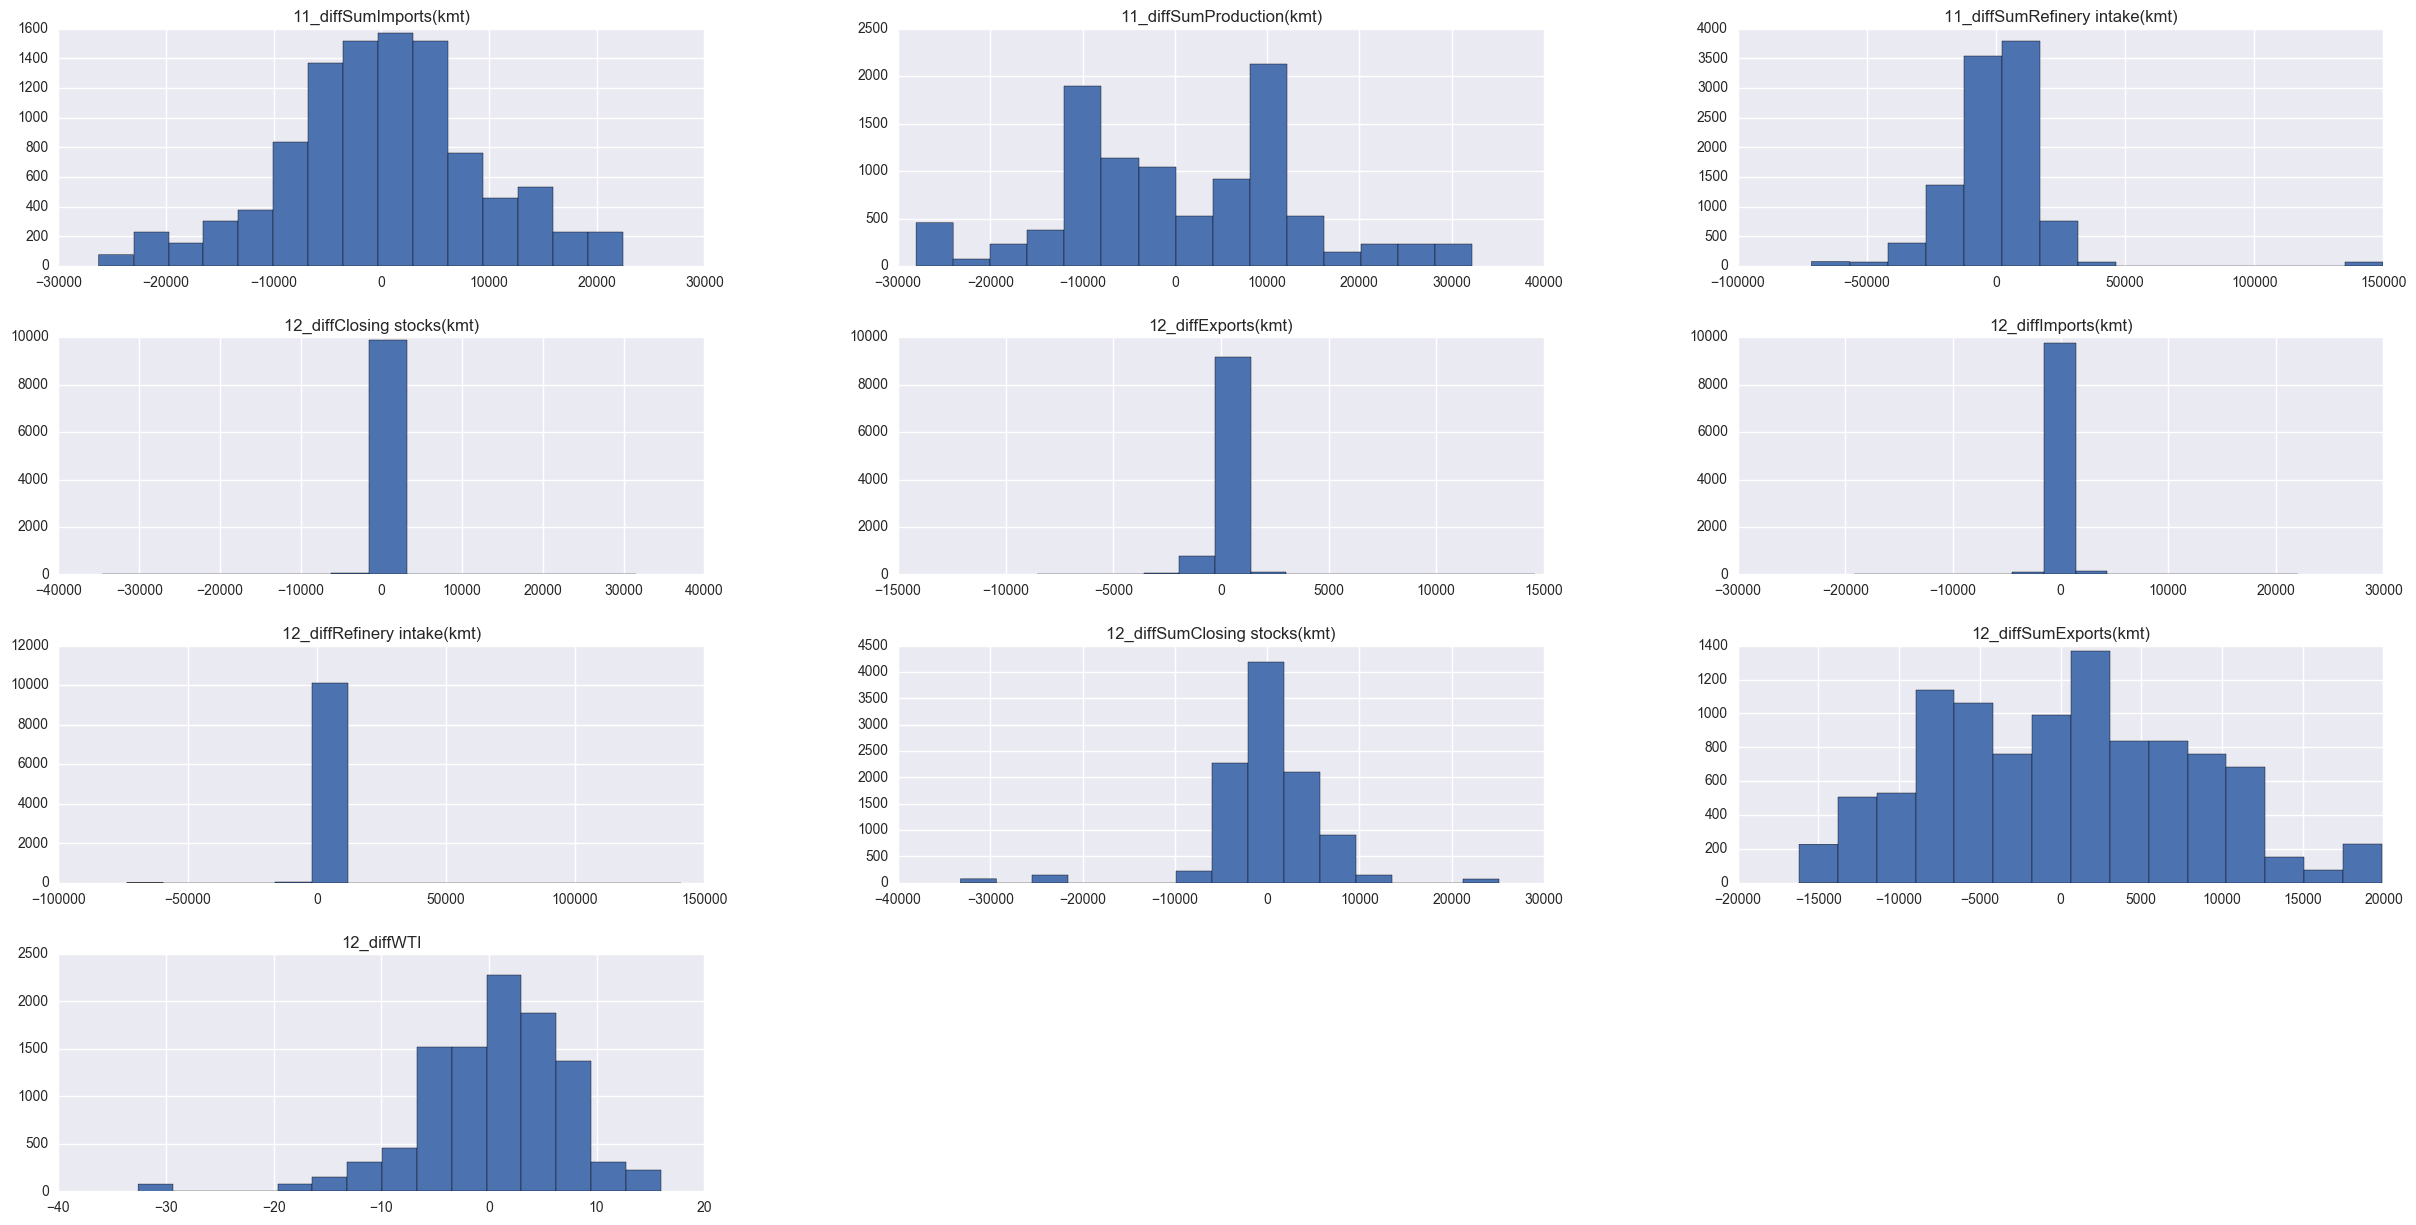

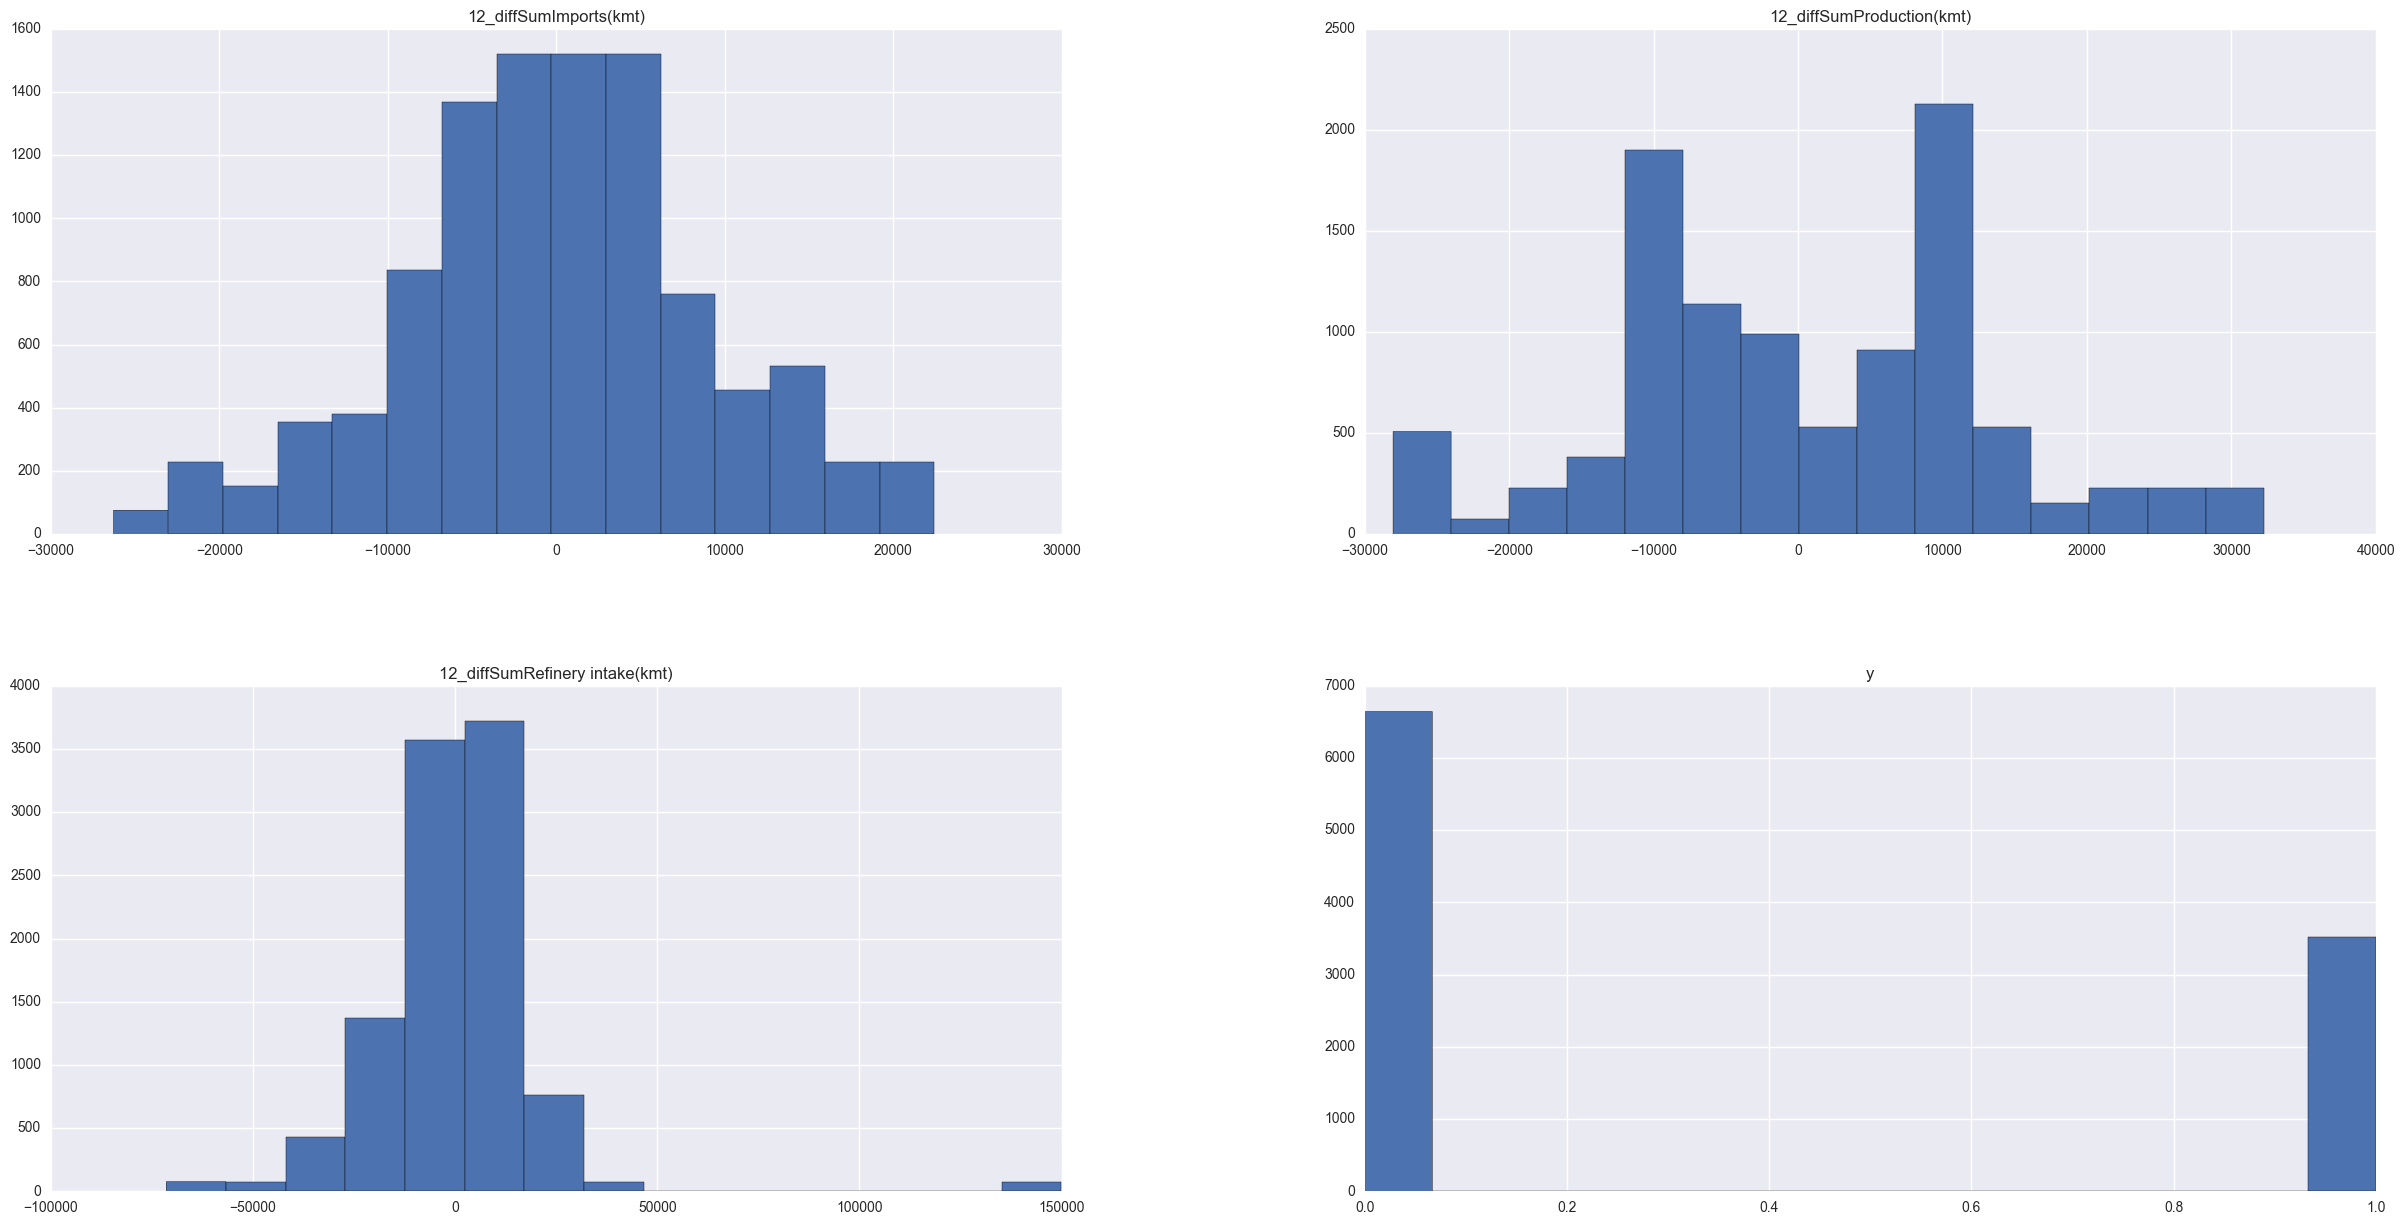

In [35]:
%%time
data_train.ix[:,:10].hist(bins=15, figsize=(30, 15));
data_train.ix[:,10:20].hist(bins=15, figsize=(30, 15));
data_train.ix[:,20:30].hist(bins=15, figsize=(30, 15));
data_train.ix[:,30:40].hist(bins=15, figsize=(30, 15));
data_train.ix[:,40:50].hist(bins=15, figsize=(30, 15));
data_train.ix[:,50:60].hist(bins=15, figsize=(30, 15));
data_train.ix[:,60:70].hist(bins=15, figsize=(30, 15));
data_train.ix[:,70:80].hist(bins=15, figsize=(30, 15));
data_train.ix[:,80:90].hist(bins=15, figsize=(30, 15));
data_train.ix[:,90:100].hist(bins=15, figsize=(30, 15));
data_train.ix[:,100:110].hist(bins=15, figsize=(30, 15));
data_train.ix[:,110:120].hist(bins=15, figsize=(30, 15));
data_train.ix[:,120:].hist(bins=15, figsize=(30, 15));

### PCA viz

Explained variance =  41.2619129047


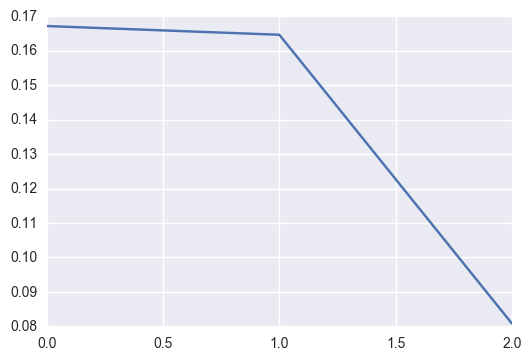

In [28]:
pca = PCA(n_components=3)
Y = pca.fit_transform(data_train.drop(["ID","month", "country","y"], axis=1).dropna())
print "Explained variance = ",100 * pca.explained_variance_ratio_.sum()
plt.plot(pca.explained_variance_ratio_);

In [67]:
import plotly.offline as py
import plotly.graph_objs as go

import numpy as np

trace1 = go.Scatter3d(
    x=Y[:,0],
    y=Y[:,1],
    z=Y[:,2],
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        color=data_train.y,
        opacity=0.8
    ),
    text=data_train.y,
    hoverinfo='text',
    name='3D PCA'
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    title='3D PCA vizualization',
    scene=go.Scene(
    xaxis=dict(
        title='1st PCA component',
    ),
    yaxis=dict(
        title='2nd PCA component',
      ),
    zaxis=dict(
        title='2nd PCA component',
    )
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='3D PCA vizualization')

## Prediction

In [7]:
%%time
xgbclf = xgb.XGBClassifier(max_depth=50,
#                                learning_rate=0.065,
                                learning_rate=0.1,
                                n_estimators=100, 
                                silent=1,
                                objective='binary:logistic', 
                                nthread=3, 
                                gamma=0.001,
                                min_child_weight=1, 
                                max_delta_step=0,
                                subsample=1, 
                                colsample_bytree=1, 
                                colsample_bylevel=1, 
                                reg_alpha=0, 
                                reg_lambda=1, 
                                scale_pos_weight=1, 
                                base_score=0.508, 
                                seed=0, 
                                missing=None)

CPU times: user 20 µs, sys: 1e+03 ns, total: 21 µs
Wall time: 23.1 µs


We dummify our categorical features :
- country
- month

In [8]:
data_train = pd.get_dummies(data_train, prefix=['country', 'month'], columns=['country', 'month'],drop_first=True)

In [9]:
x = data_train.drop(['ID','y'],axis=1)
y = data_train["y"]
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

In [20]:
%%time
estimator = xgbclf
results = cross_val_score(estimator, x, y, cv=kfold, n_jobs=1, scoring="roc_auc")
print("Results: %.2f%% (%.2f%%) on %d stratkfolds" % (results.mean()*100, results.std()*100, kfold.get_n_splits()))

Results: 80.84% (0.89%) on 5 stratkfolds
CPU times: user 4min 32s, sys: 6.96 s, total: 4min 39s
Wall time: 2min


### Pipelinization
Let us create a pipeline to avoid changing our training set.  
We will see what gives better performance between :
- imputing NaNs with mean
- imputing NaNs with median
- drop NaNs

Imputing with mean

In [21]:
pip_clf = make_pipeline(
            Imputer(strategy='mean'),
            xgbclf)

In [22]:
%%time
estimator = pip_clf
results = cross_val_score(estimator, x, y, cv=kfold, n_jobs=1, scoring="roc_auc")
print("Results: %.2f%% (%.2f%%) on %d stratkfolds" % (results.mean()*100, results.std()*100, kfold.get_n_splits()))

Results: 81.06% (0.91%) on 5 stratkfolds
CPU times: user 4min 13s, sys: 7.73 s, total: 4min 21s
Wall time: 2min 18s


Imputing with median

In [23]:
pip_clf = make_pipeline(
            Imputer(strategy='median'),
            xgbclf)

In [24]:
%%time
estimator = pip_clf
results = cross_val_score(estimator, x, y, cv=kfold, n_jobs=1, scoring="roc_auc")
print("Results: %.2f%% (%.2f%%) on %d stratkfolds" % (results.mean()*100, results.std()*100, kfold.get_n_splits()))

Results: 80.97% (0.66%) on 5 stratkfolds
CPU times: user 4min 9s, sys: 7.63 s, total: 4min 17s
Wall time: 1min 58s


Dropping NaNs

In [30]:
%%time
estimator = xgbclf
results = cross_val_score(estimator, data_train.drop(['ID','y'],axis=1).dropna(), data_train["y"].ix[data_train.drop(['ID','y'],axis=1).dropna().index], cv=kfold, n_jobs=1, scoring="roc_auc")
print("Results: %.2f%% (%.2f%%) on %d stratkfolds" % (results.mean()*100, results.std()*100, kfold.get_n_splits()))

Results: 80.71% (0.89%) on 5 stratkfolds
CPU times: user 4min, sys: 6.17 s, total: 4min 6s
Wall time: 1min 42s


Imputing with mean gives the best results in average.

### Fitting

In [10]:
pip_clf = make_pipeline(
            Imputer(strategy='median'),
            xgbclf)

In [132]:
%%time
pip_clf.fit(x,y)

CPU times: user 38.3 s, sys: 1.68 s, total: 40 s
Wall time: 12.9 s


Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('xgbclassifier', XGBClassifier(base_score=0.508, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.001, learning_rate=0.1, max_delta_step=0, max_depth=50,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=1, subsample=1))])

In [13]:
def objective_function(x_int):
    objective_function.n_iterations += 1
    n_estimators, max_depth = x_int
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    clf = pip_clf
    scores = cross_val_score(clf, x, y, cv=kfold, scoring='roc_auc')
    print objective_function.n_iterations, \
        ": n_estimators = ", n_estimators, \
        "\tmax_depth = ", max_depth, \
        "accuracy = ", np.mean(scores)
    return 1 - np.mean(scores)

In [14]:
from hyperopt import fmin as hyperopt_fmin
from hyperopt import tpe, hp, STATUS_OK, space_eval

objective_function.n_iterations = 0
best = hyperopt_fmin(objective_function,
                    space=(hp.qloguniform('n_estimators', np.log(10), np.log(1000), 10), 
                           hp.qloguniform('max_depth', np.log(2), np.log(100), 1)),
                    algo=tpe.suggest,
                    max_evals=10)

1 : n_estimators =  530 	max_depth =  63 accuracy =  0.809704693177
2 : n_estimators =  260 	max_depth =  27 accuracy =  0.809704693177


KeyboardInterrupt: 

In [15]:
from pysmac.optimize import fmin as smac_fmin

objective_function.n_iterations = 0
xmin, fval = smac_fmin(objective_function, 
                  #x0=(0,0), xmin=(-5, 0), xmax=(10, 15), 
                  x0_int=(1,1), xmin_int=(1, 1), xmax_int=(1000, 100), 
                  max_evaluations=10)

1 : n_estimators =  1 	max_depth =  1 accuracy =  0.809704693177
Number of evaluations 1, current fmin: 0.190295
2 : n_estimators =  416 	max_depth =  74 accuracy =  0.809704693177


Number of evaluations 2, fmin: 0.190295


### Roc curve
Our logistic regression model allows us to plot ROC curves.  
We have:
True Positive Rate = True Positive / (TP + FN)
False Positive Rate = False Positive / (TN + FP)  
We plot a Receiver Operating Characteristic (ROC) curve, to illustrate the performance of our binary classifier system as its discrimination threshold (probability) is varied (ROC visualizes performance for all classification thresholds).  
We see that our LogisticRegression classifier does a good job separating our two imbalanced classes.

CPU times: user 1min 12s, sys: 1.51 s, total: 1min 14s
Wall time: 28.9 s


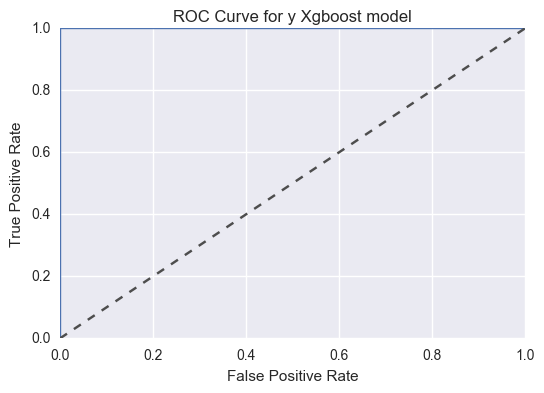

In [19]:
%%time
xgbclf.fit(x,y)
probas_y = xgbclf.predict_proba(x)
fig, ax = plt.subplots()
plt.title('ROC Curve for y Xgboost model')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.plot(roc_curve(y, probas_y[:,1])[0], roc_curve(y, probas_y[:,1])[1])
# We also plot y = x
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

### Make prediction

In [133]:
%%time
y_pred = pd.DataFrame()
y_pred['ID'] = data_test['ID']
y_pred['Target'] = pip_clf.predict_proba((data_test.drop(["ID"],axis=1)))[:,1]

CPU times: user 61.3 ms, sys: 8.18 ms, total: 69.5 ms
Wall time: 41 ms


### Print prediction

In [134]:
y_pred.to_csv('submissions/xgb_test_proba_mean.csv', index=False)

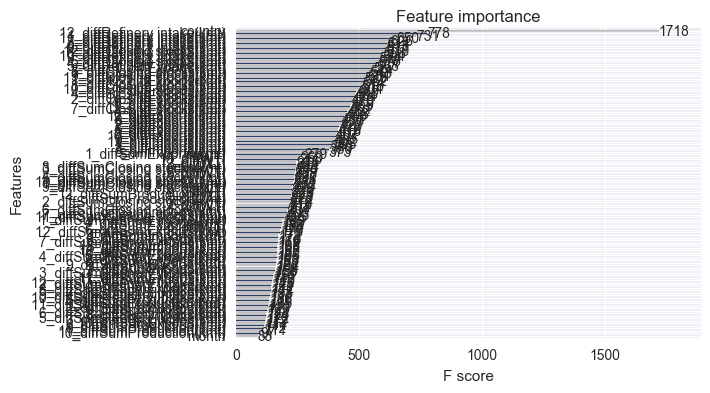

In [145]:
xgb.plot_importance(xgbclf);

In [153]:
time_range = pd.date_range(start='1/1/2015', end='31/12/2015', freq='M')

In [165]:
df = pd.DataFrame(index=time_range, columns=['ID', 'month_rec', 'country' ,'diffClosing stocks(kmt)', 
                                             'diffExports(kmt)', 'diffImports(kmt)', 'diffRefinery intake(kmt)', 
                                             'diffWTI', 'diffSumClosing stocks(kmt)', 'diffSumExports(kmt)', 
                                             'diffSumImports(kmt)', 'diffSumProduction(kmt)', 
                                             'diffSumRefinery intake(kmt)'])

In [161]:
df

ID month_rec country diffClosing stocks(kmt) diffExports(kmt)  \
2015-01-31  NaN       NaN     NaN                     NaN              NaN   
2015-02-28  NaN       NaN     NaN                     NaN              NaN   
2015-03-31  NaN       NaN     NaN                     NaN              NaN   
2015-04-30  NaN       NaN     NaN                     NaN              NaN   
2015-05-31  NaN       NaN     NaN                     NaN              NaN   
2015-06-30  NaN       NaN     NaN                     NaN              NaN   
2015-07-31  NaN       NaN     NaN                     NaN              NaN   
2015-08-31  NaN       NaN     NaN                     NaN              NaN   
2015-09-30  NaN       NaN     NaN                     NaN              NaN   
2015-10-31  NaN       NaN     NaN                     NaN              NaN   
2015-11-30  NaN       NaN     NaN                     NaN              NaN   
2015-12-31  NaN       NaN     NaN                     NaN              NaN   

           diffImports(kmt) diffRefinery intake(kmt) diffWTI  \
2015-01-31              NaN                      NaN     NaN   
2015-02-28              NaN                      NaN     NaN   
2015-03-31              NaN                      NaN     NaN   
2015-04-30              NaN                      NaN     NaN   
2015-05-31              NaN                      NaN     NaN   
2015-06-30              NaN                      NaN     NaN   
2015-07-31              NaN                      NaN     NaN   
2015-08-31              NaN                      NaN     NaN   
2015-09-30              NaN                      NaN     NaN   
2015-10-31              NaN                      NaN     NaN   
2015-11-30              NaN                      NaN     NaN   
2015-12-31              NaN                      NaN     NaN   

           diffSumClosing stocks(kmt) diffSumExports(kmt) diffSumImports(kmt)  \
2015-01-31                        NaN                 NaN                 NaN   
2015-02-28                        NaN                 NaN                 NaN   
2015-03-31                        NaN                 NaN                 NaN   
2015-04-30                        NaN                 NaN                 NaN   
2015-05-31                        NaN                 NaN                 NaN   
2015-06-30                        NaN                 NaN                 NaN   
2015-07-31                        NaN                 NaN                 NaN   
2015-08-31                        NaN                 NaN                 NaN   
2015-09-30                        NaN                 NaN                 NaN   
2015-10-31                        NaN                 NaN                 NaN   
2015-11-30                        NaN                 NaN                 NaN   
2015-12-31                        NaN                 NaN                 NaN   

           diffSumProduction(kmt) diffSumRefinery intake(kmt)  
2015-01-31                    NaN                         NaN  
2015-02-28                    NaN                         NaN  
2015-03-31                    NaN                         NaN  
2015-04-30                    NaN                         NaN  
2015-05-31                    NaN                         NaN  
2015-06-30                    NaN                         NaN  
2015-07-31                    NaN                         NaN  
2015-08-31                    NaN                         NaN  
2015-09-30                    NaN                         NaN  
2015-10-31                    NaN                         NaN  
2015-11-30                    NaN                         NaN  
2015-12-31                    NaN                         NaN

In [171]:
df['country'].ix['2015-01-31'] = 1

In [178]:
time_range

DatetimeIndex(['2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30', '2015-10-31', '2015-11-30', '2015-12-31'],
              dtype='datetime64[ns]', freq='M')

In [183]:
datacols = df.columns.tolist()[3:]
print datacols

['diffClosing stocks(kmt)', 'diffExports(kmt)', 'diffImports(kmt)', 'diffRefinery intake(kmt)', 'diffWTI', 'diffSumClosing stocks(kmt)', 'diffSumExports(kmt)', 'diffSumImports(kmt)', 'diffSumProduction(kmt)', 'diffSumRefinery intake(kmt)']


In [191]:
%%time
for j in range(data_train.shape[0]):
    row = data_train.ix[j,:]
    for i in range(len(time_range)):
        df['country'].ix[time_range[i]] = row['country']
        df['month_rec'].ix[time_range[i]] = row['month'] 
        df['ID'].ix[time_range[i]] = row['ID'] 
        for datacol in datacols:
            df[datacol].ix[time_range[i]] = row[str(i+1)+'_'+datacol]

CPU times: user 6min 43s, sys: 2.65 s, total: 6min 46s
Wall time: 6min 52s


In [192]:
df

ID month_rec country diffClosing stocks(kmt)  \
2015-01-31  ID10159         3      76                -252.429   
2015-02-28  ID10159         3      76                -602.857   
2015-03-31  ID10159         3      76                 155.571   
2015-04-30  ID10159         3      76                -26.7143   
2015-05-31  ID10159         3      76                 372.143   
2015-06-30  ID10159         3      76                 103.571   
2015-07-31  ID10159         3      76                    -108   
2015-08-31  ID10159         3      76                 354.286   
2015-09-30  ID10159         3      76                -507.714   
2015-10-31  ID10159         3      76                -76.8571   
2015-11-30  ID10159         3      76                 51.1428   
2015-12-31  ID10159         3      76                     157   

           diffExports(kmt) diffImports(kmt) diffRefinery intake(kmt) diffWTI  \
2015-01-31         -487.143           8.8571                  1049.57   -0.37   
2015-02-28          429.143              -68                 -435.571    8.62   
2015-03-31         -827.714         -42.7143                  280.571   -4.05   
2015-04-30           2.7143          135.714                 -480.857    1.86   
2015-05-31          183.286              -87                  148.714  -18.37   
2015-06-30              481          35.5714                 -418.714   -1.48   
2015-07-31          781.143          97.2857                  232.714    3.04   
2015-08-31         -17.7143         -22.1428                 -606.714    8.39   
2015-09-30         -244.857         -156.571                  129.714   -4.29   
2015-10-31         -361.857         -16.1429                  100.572   -5.95   
2015-11-30         -383.857          54.7143                     -482    2.31   
2015-12-31          1601.71         -41.4286                     -851    3.29   

           diffSumClosing stocks(kmt) diffSumExports(kmt) diffSumImports(kmt)  \
2015-01-31                    7872.16             1455.82             8591.65   
2015-02-28                    1157.71               -4469            -9726.73   
2015-03-31                    5542.78              6826.3             3963.05   
2015-04-30                    4542.36            -6912.56            -3970.63   
2015-05-31                     1158.3             5592.95             7813.33   
2015-06-30                    -1686.5            -1267.98            -8694.75   
2015-07-31                   -3143.23            -566.642             5975.34   
2015-08-31                   -1105.62             30.1372            -1947.55   
2015-09-30                    192.814            -7366.65            -7502.34   
2015-10-31                    195.201              7500.1             6335.01   
2015-11-30                    1655.52            -3691.71            -836.242   
2015-12-31                      -5670             6087.29            -305.707   

           diffSumProduction(kmt) diffSumRefinery intake(kmt)  
2015-01-31                4178.01                     1082.39  
2015-02-28               -16917.8                    -15146.8  
2015-03-31                20820.2                     17470.8  
2015-04-30               -7432.57                      -14677  
2015-05-31                6655.94                       13708  
2015-06-30               -9467.83                     -7946.3  
2015-07-31                9230.87                     15595.9  
2015-08-31                1164.37                    -1502.64  
2015-09-30               -10874.9                    -15372.2  
2015-10-31                12732.1                     9538.82  
2015-11-30               -4159.02                    -4154.01  
2015-12-31                8436.46                     12519.3

In [193]:
df.to_pickle('tmp/train_data_over_time')